In [1]:
import sys

if "google.colab" in sys.modules:
    !pip3 install imbalanced-learn
    !pip3 install xgboost==1.7.2
    !pip install scikit-learn==1.0 -U
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pandas-profiling==2.*
    !pip install pdpbox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.7/24.7 MB 23.9 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imbalanced-learn 0.10.1 requires scikit-learn>=1.0.2, but you have scikit-learn 1.0 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pk

### About Data
- Stage #_temp : 공정 온도, 연속형 (평균 : 28 ~ 32)
- Stage #_humidity : 공정 습도, 연속형 (평균 : 67 ~ 79)
- Stage #_flow_deviation : 공정 생산약품의 유량 차이, 연속형 (평균 : -26 ~ 26)
- Stage #_density_deviation : 공정 생산약품의 밀도 차이, 연속형 (평균 : -26 ~ 26)
- Stage #_viscosity_deviation : 공정 생산약품의 점도 차이, 연속형 (평균 : -27 ~ 27)
- Stage #_o2_deviation : 공정반응에서 발생한 산소 농도 차이, 연속형 (평균 : -10 ~ 13)
- Stage #_n_deviation : 공정반응에서 발생한 질소 농도 차이, 연속형 (평균 : -11 ~ 11)
- Stage #_co2_deviation : 공정반응에서 발생한 이산화탄소 농도 차이, 연속형 (평균 : -32 ~ 28)
- label : 생산물 정상 혹은 불량 (0 or 1)

In [2]:
import re
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import KNNImputer

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot
from sklearn.inspection import PartialDependenceDisplay, partial_dependence

import eli5
from eli5.sklearn import PermutationImportance

In [3]:
# 데이터셋 불러오기

df = pd.merge(
    pd.read_csv("https://raw.githubusercontent.com/ngha6475/code_states_project/main/section_2/data/features_train.csv"),
    pd.read_csv("https://raw.githubusercontent.com/ngha6475/code_states_project/main/section_2/data/labels_train.csv"),
    left_index=True, right_index=True
)

In [4]:
df.head()

,stage1_temp,stage2_temp,stage3_temp,stage4_temp,stage5_temp,stage1_humidity,stage2_humidity,stage3_humidity,stage4_humidity,stage5_humidity,...,stage4_co2_deviation,stage4_o2_deviation,stage4_n_deviation,stage5_flow_deviation,stage5_density_deviation,stage5_viscosity_deviation,stage5_co2_deviation,stage5_o2_deviation,stage5_n_deviation,label
0,28.57,30.15,30.71,30.91,31.62,69.08,68.98,70.37,73.67,69.41,...,-0.381981,-0.917519,2.905965,NaN,14.642069,NaN,2.249968,NaN,NaN,1
1,31.74,31.29,30.92,29.52,30.70,68.24,75.97,72.06,69.72,76.11,...,NaN,-4.937284,0.089265,-4.937284,12.361204,NaN,3.381750,5.827666,-0.056206,1
2,31.25,29.16,31.45,30.74,30.26,67.98,78.42,70.97,67.71,70.73,...,5.685728,NaN,0.871249,-0.955908,1.587669,1.665659,-0.052572,-0.597566,-2.745544,0
3,29.96,29.22,28.39,31.96,31.12,68.60,67.80,70.09,71.88,76.71,...,5.497906,-2.134062,-1.188985,-2.134062,NaN,NaN,3.230979,-0.032255,0.157905,0
4,30.09,29.58,28.06,30.46,28.84,78.24,67.31,72.63,77.78,74.76,...,7.259878,-0.192612,-1.648626,-0.192612,9.741397,NaN,-0.516248,2.129390,0.020616,0


In [5]:
df.shape

(16998, 41)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16998 entries, 0 to 16997
Data columns (total 41 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   stage1_temp                 16998 non-null  float64
 1   stage2_temp                 16998 non-null  float64
 2   stage3_temp                 16998 non-null  float64
 3   stage4_temp                 16998 non-null  float64
 4   stage5_temp                 16998 non-null  float64
 5   stage1_humidity             16998 non-null  float64
 6   stage2_humidity             16998 non-null  float64
 7   stage3_humidity             16998 non-null  float64
 8   stage4_humidity             16998 non-null  float64
 9   stage5_humidity             16998 non-null  float64
 10  stage1_flow_deviation       11188 non-null  float64
 11  stage1_density_deviation    16073 non-null  float64
 12  stage1_viscosity_deviation  15591 non-null  float64
 13  stage1_co2_deviation        106

In [7]:
df.isnull().sum()

stage1_temp                      0
stage2_temp                      0
stage3_temp                      0
stage4_temp                      0
stage5_temp                      0
stage1_humidity                  0
stage2_humidity                  0
stage3_humidity                  0
stage4_humidity                  0
stage5_humidity                  0
stage1_flow_deviation         5810
stage1_density_deviation       925
stage1_viscosity_deviation    1407
stage1_co2_deviation          6348
stage1_o2_deviation           2138
stage1_n_deviation             917
stage2_flow_deviation         1356
stage2_density_deviation      2506
stage2_viscosity_deviation    5622
stage2_co2_deviation          2239
stage2_o2_deviation           1411
stage2_n_deviation            2352
stage3_flow_deviation         2913
stage3_density_deviation       866
stage3_viscosity_deviation    2904
stage3_co2_deviation          2629
stage3_o2_deviation           1717
stage3_n_deviation            1246
stage4_flow_deviatio

In [8]:
cols = df.columns.to_list()

stage1_cols = [s for s in cols if 'stage1' in s]
stage2_cols = [s for s in cols if 'stage2' in s]
stage3_cols = [s for s in cols if 'stage3' in s]
stage4_cols = [s for s in cols if 'stage4' in s]
stage5_cols = [s for s in cols if 'stage5' in s]

In [9]:
stage1_cols

['stage1_temp',
 'stage1_humidity',
 'stage1_flow_deviation',
 'stage1_density_deviation',
 'stage1_viscosity_deviation',
 'stage1_co2_deviation',
 'stage1_o2_deviation',
 'stage1_n_deviation']

In [10]:
def feature_boxplot(df, cols):
    title = cols[0].split('_')[0]

    fig = plt.figure()
    fig.set_size_inches(20, 20)
    (ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8) = fig.subplots(nrows=4, ncols=2)

    sns.boxplot(data=df, x='label', y=cols[0], ax=ax1)
    ax1.set_title(cols[0])
    sns.boxplot(data=df, x='label', y=cols[1], ax=ax2)
    ax2.set_title(cols[1])
    sns.boxplot(data=df, x='label', y=cols[2], ax=ax3)
    ax3.set_title(cols[2])
    sns.boxplot(data=df, x='label', y=cols[3], ax=ax4)
    ax4.set_title(cols[3])
    sns.boxplot(data=df, x='label', y=cols[4], ax=ax5)
    ax5.set_title(cols[4])
    sns.boxplot(data=df, x='label', y=cols[5], ax=ax6)
    ax6.set_title(cols[5])
    sns.boxplot(data=df, x='label', y=cols[6], ax=ax7)
    ax7.set_title(cols[6])
    sns.boxplot(data=df, x='label', y=cols[7], ax=ax8)
    ax8.set_title(cols[7])

    fig.suptitle(title, fontsize=15, y=1.03)
    fig.tight_layout()

    plt.show()

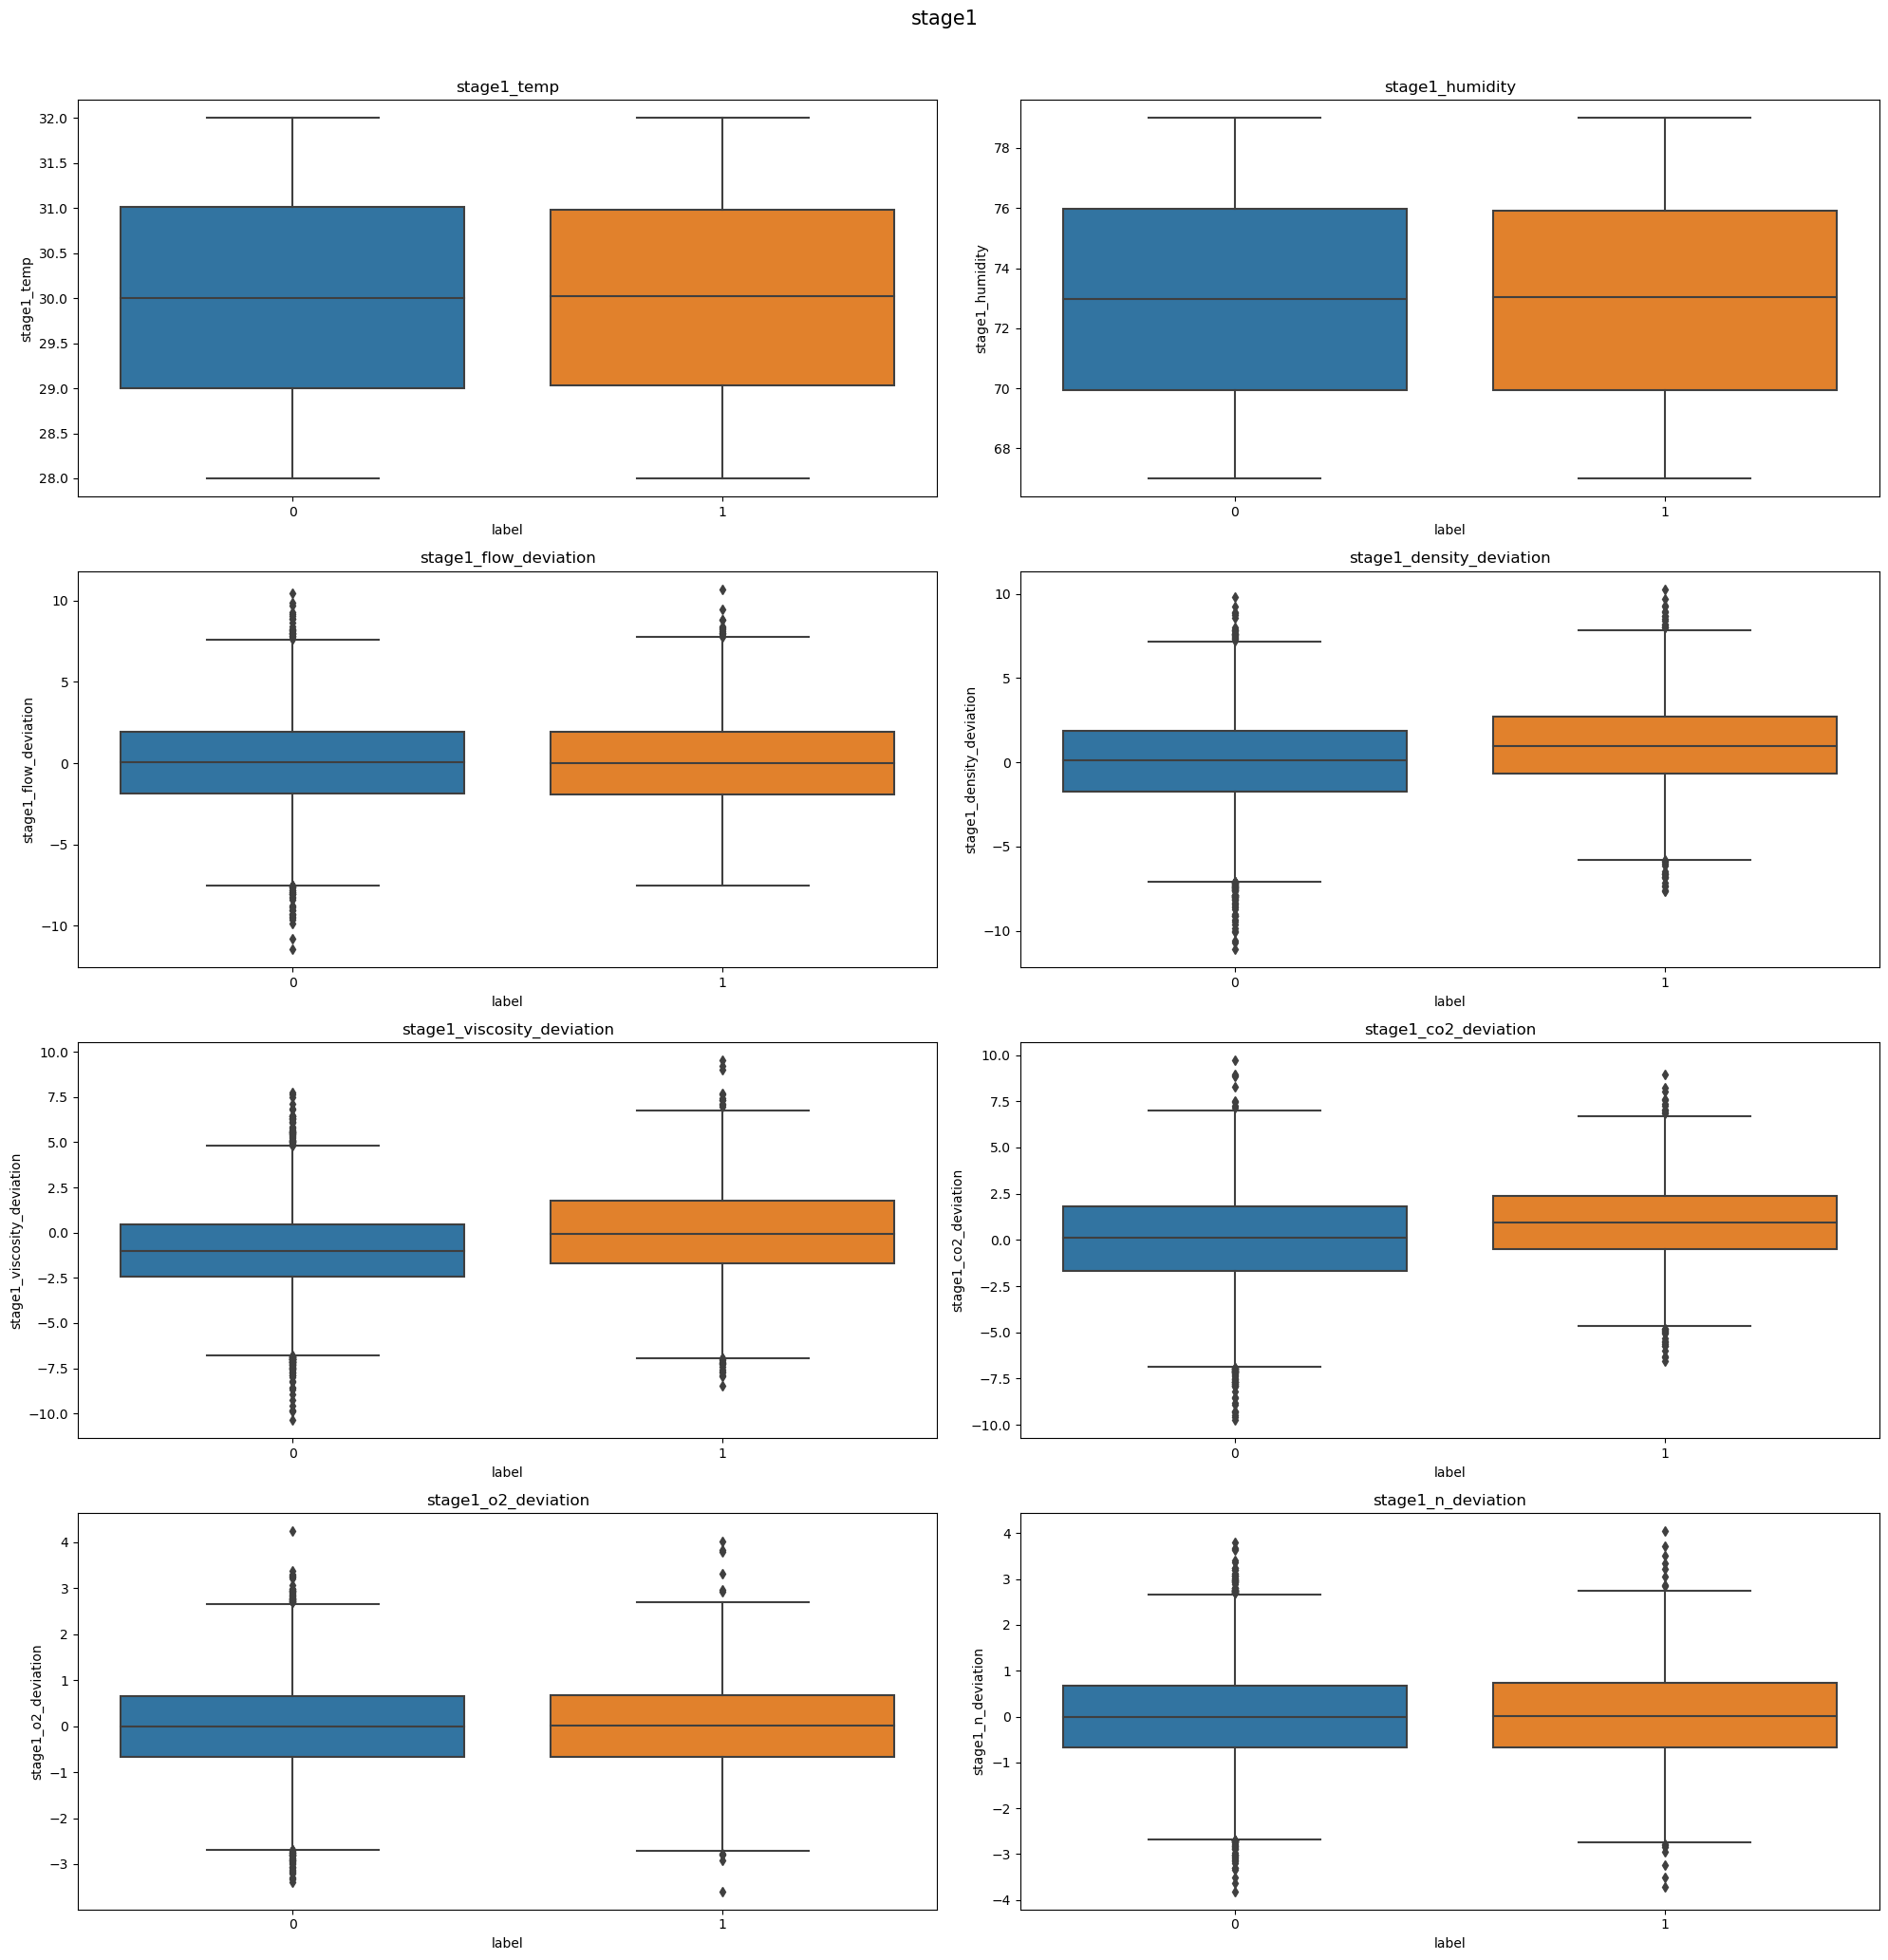

In [11]:
feature_boxplot(df, stage1_cols)

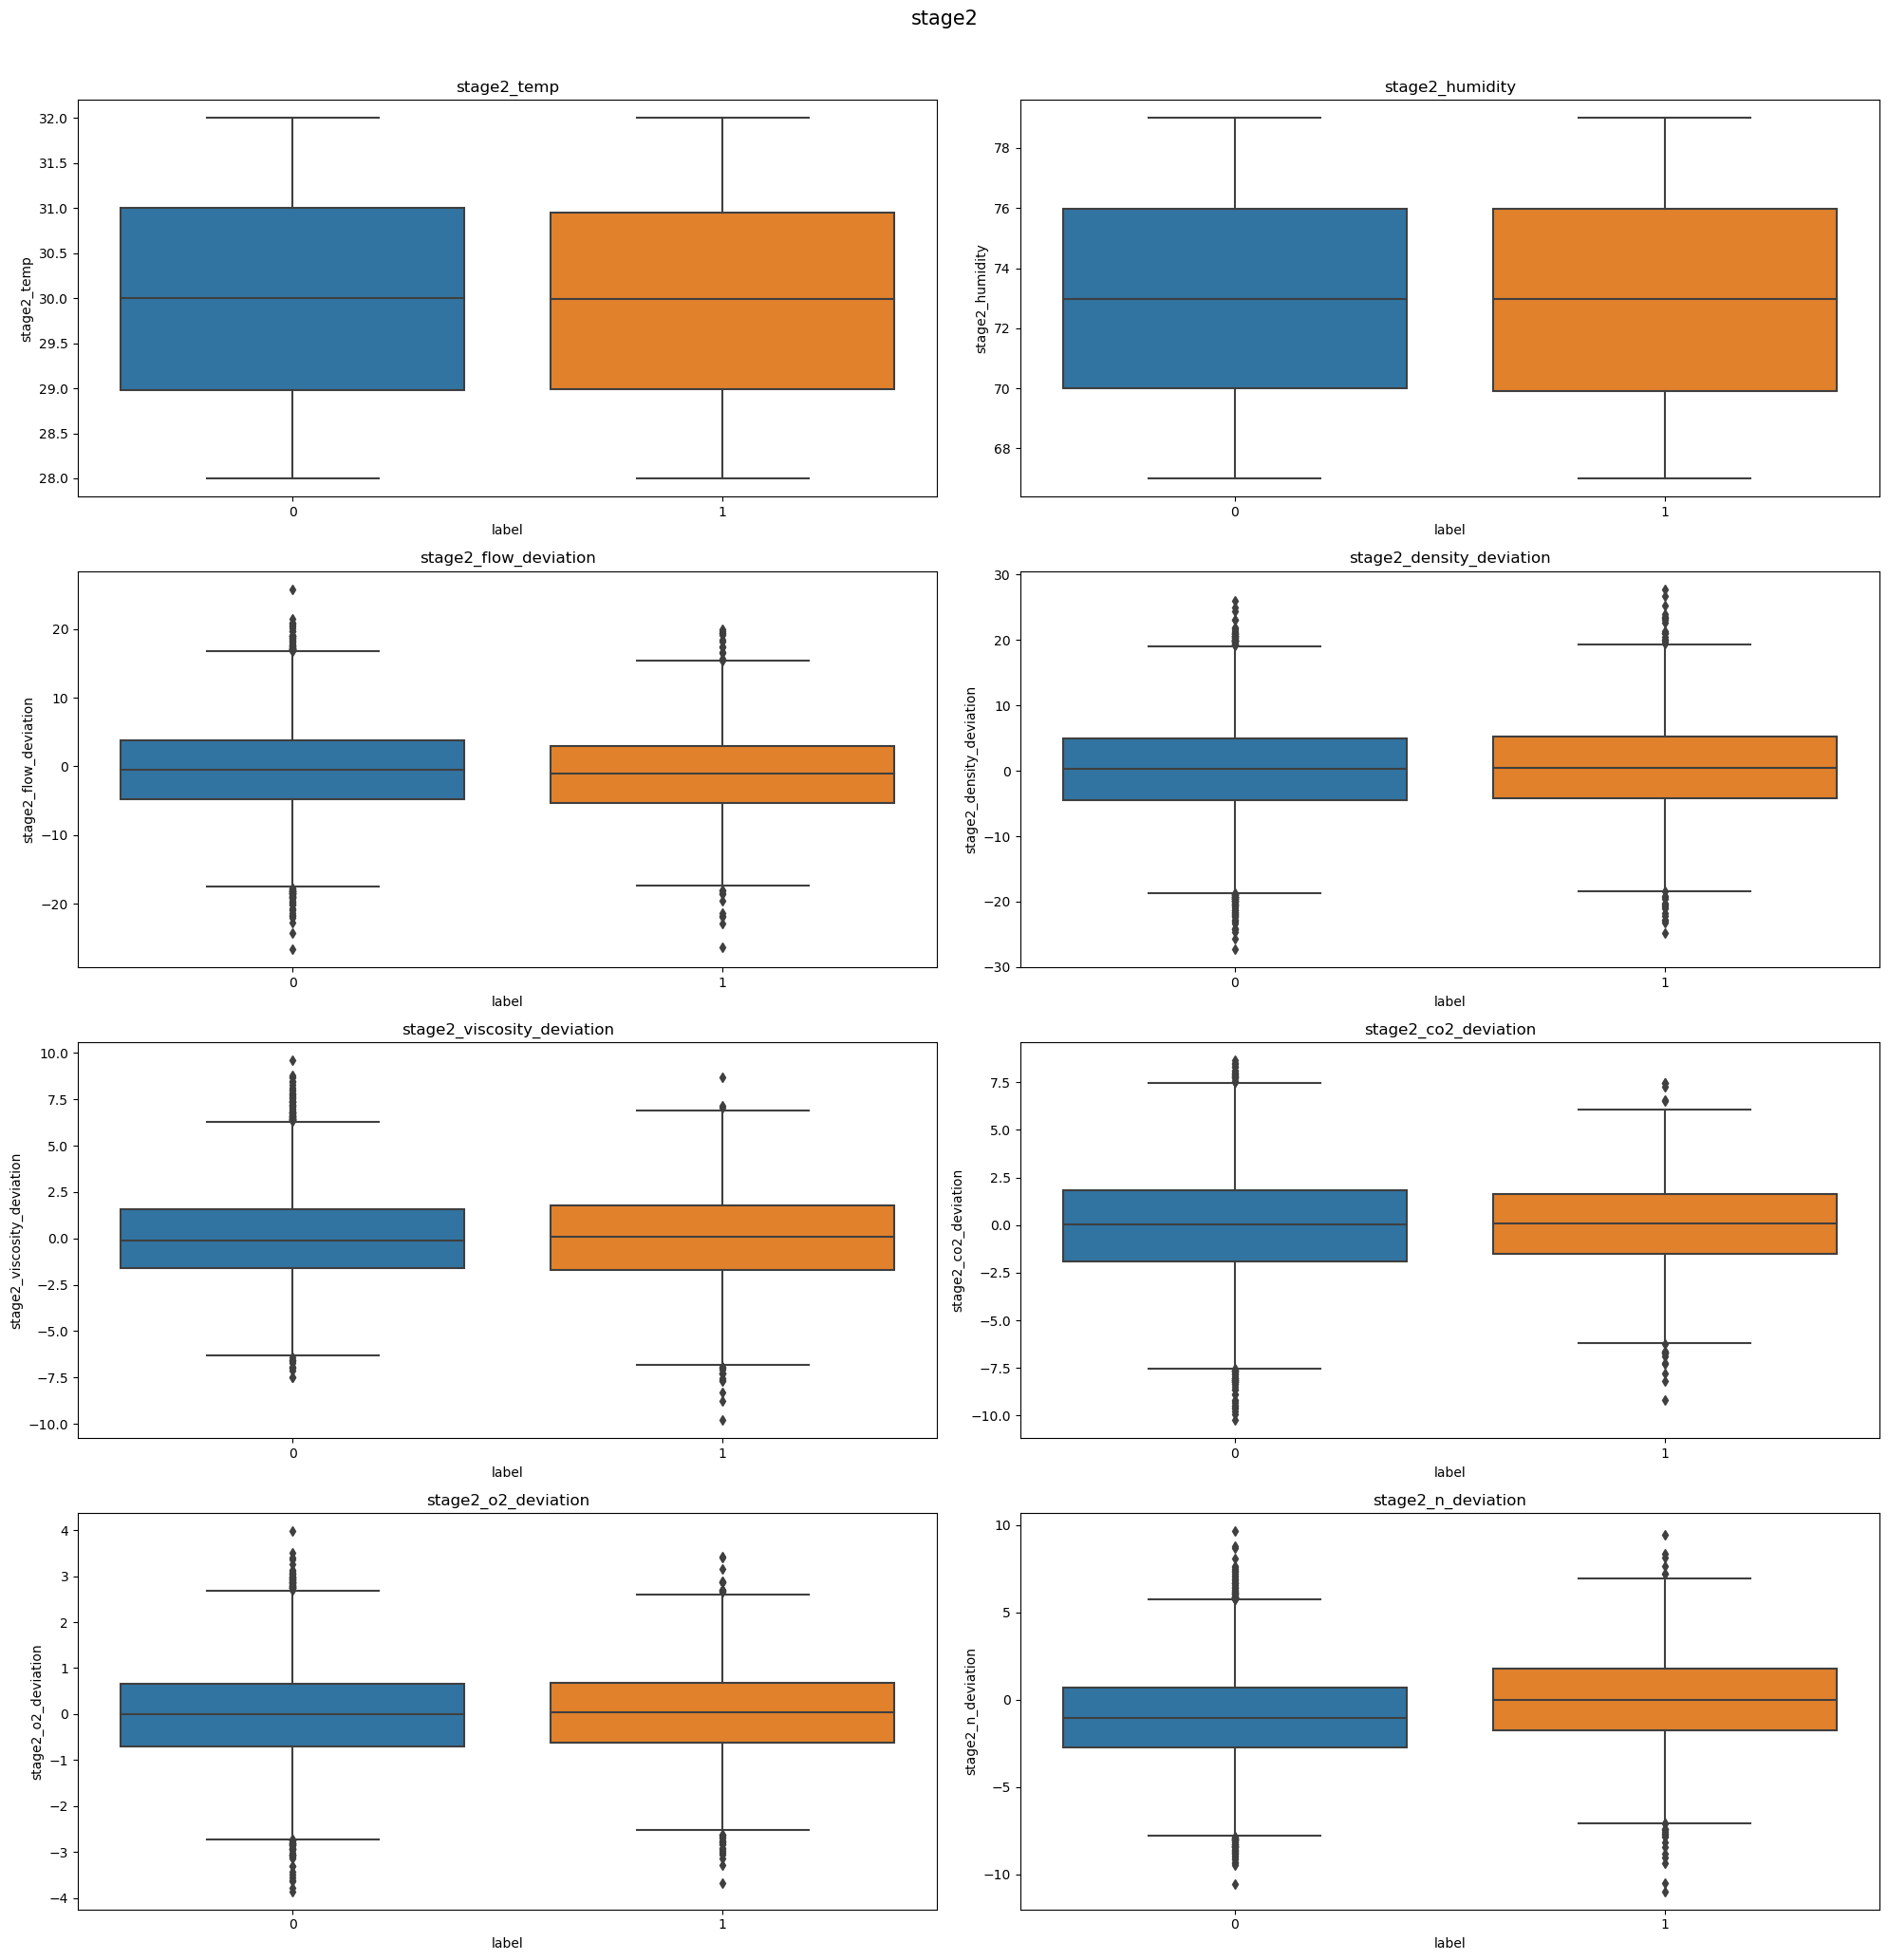

In [12]:
feature_boxplot(df, stage2_cols)

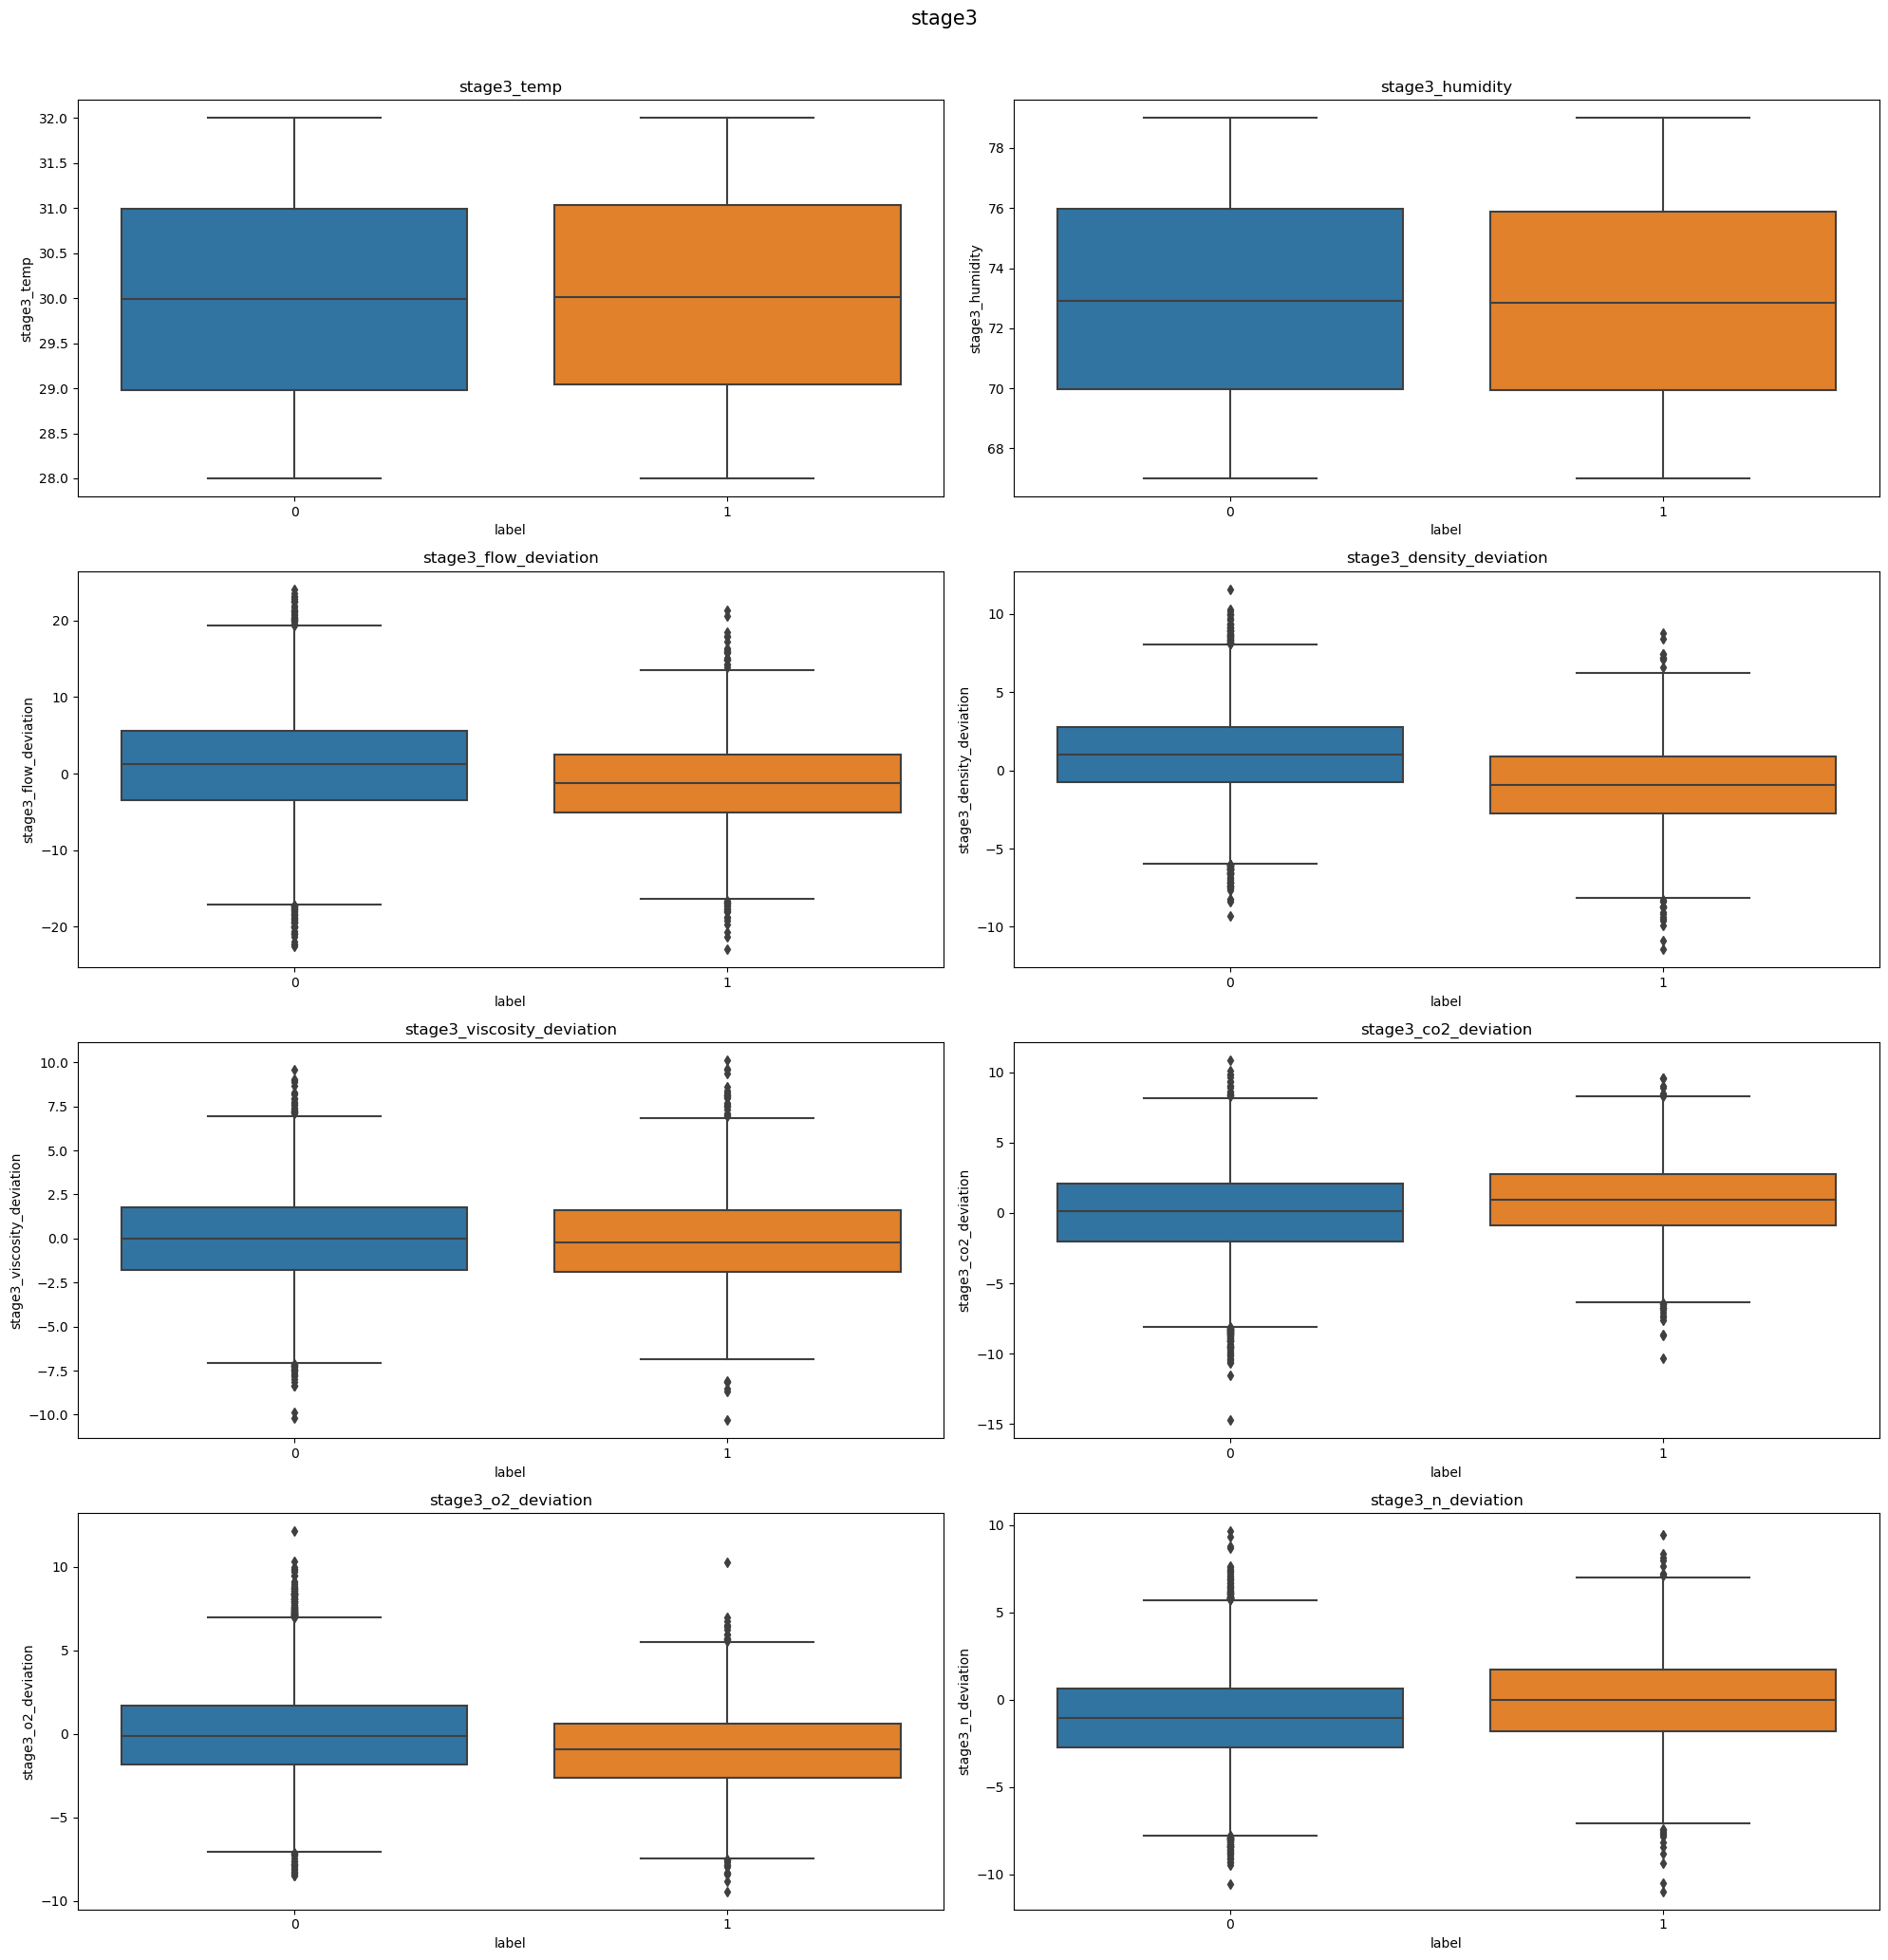

In [13]:
feature_boxplot(df, stage3_cols)

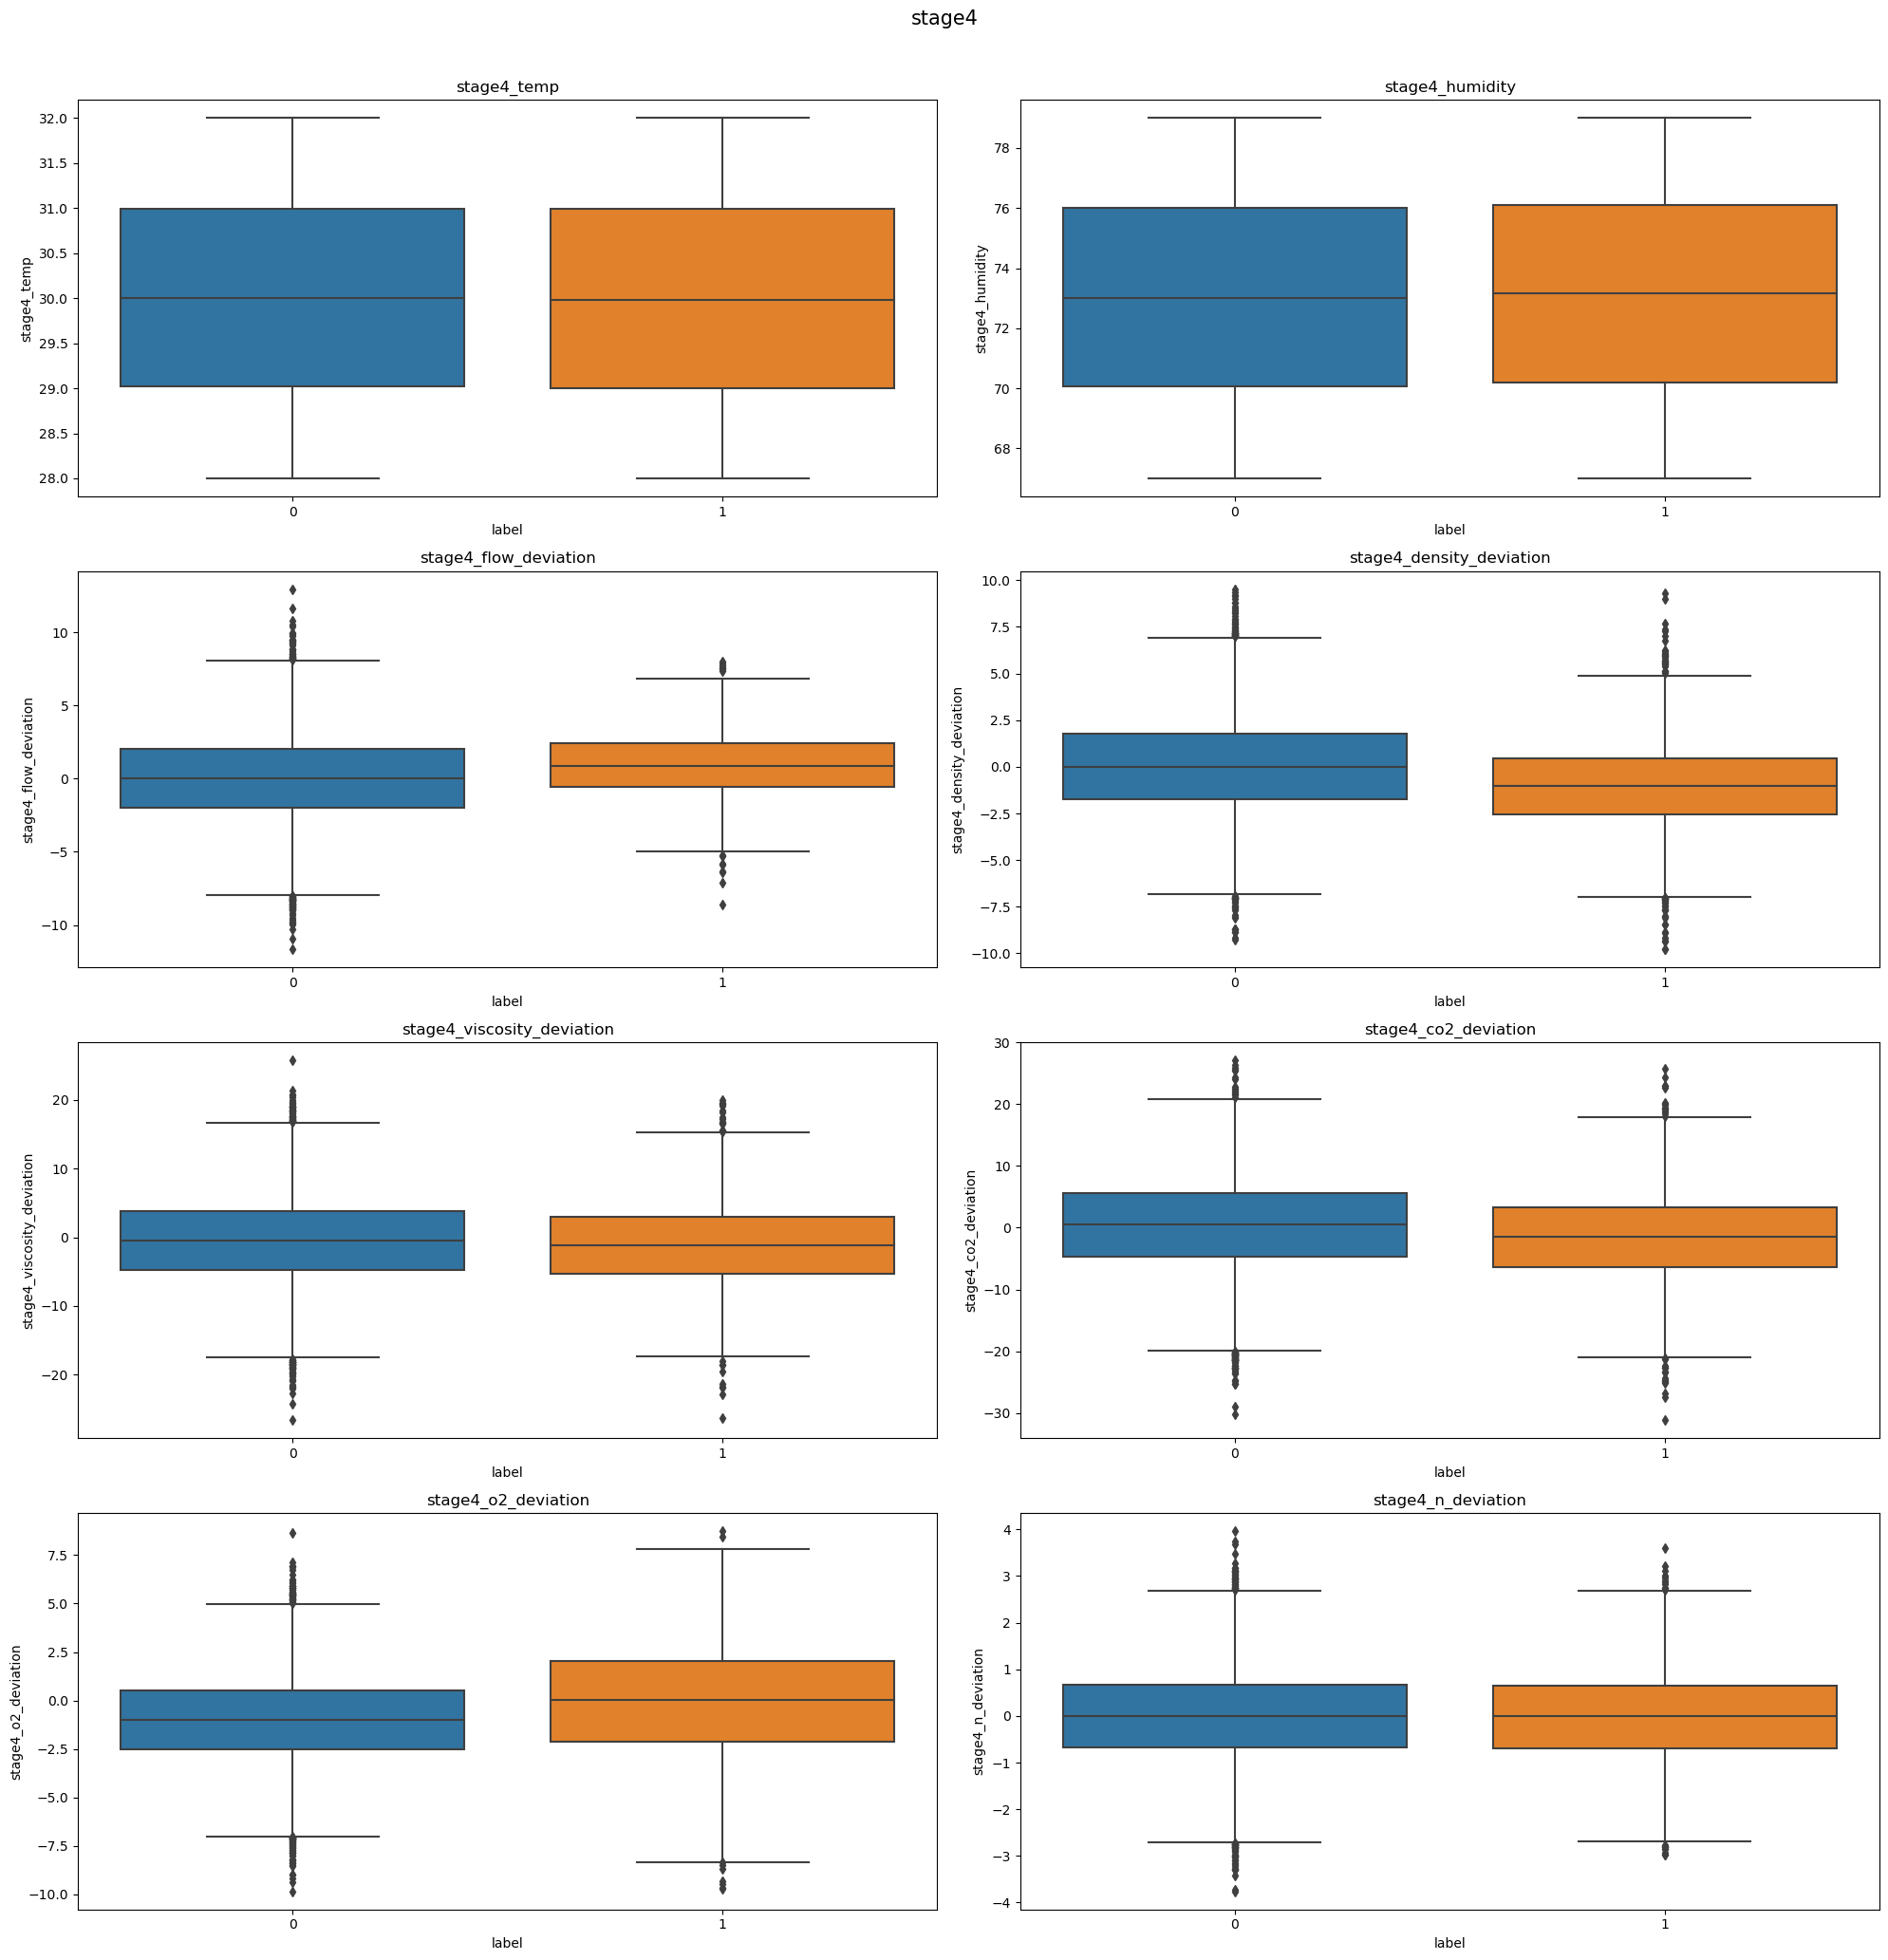

In [14]:
feature_boxplot(df, stage4_cols)

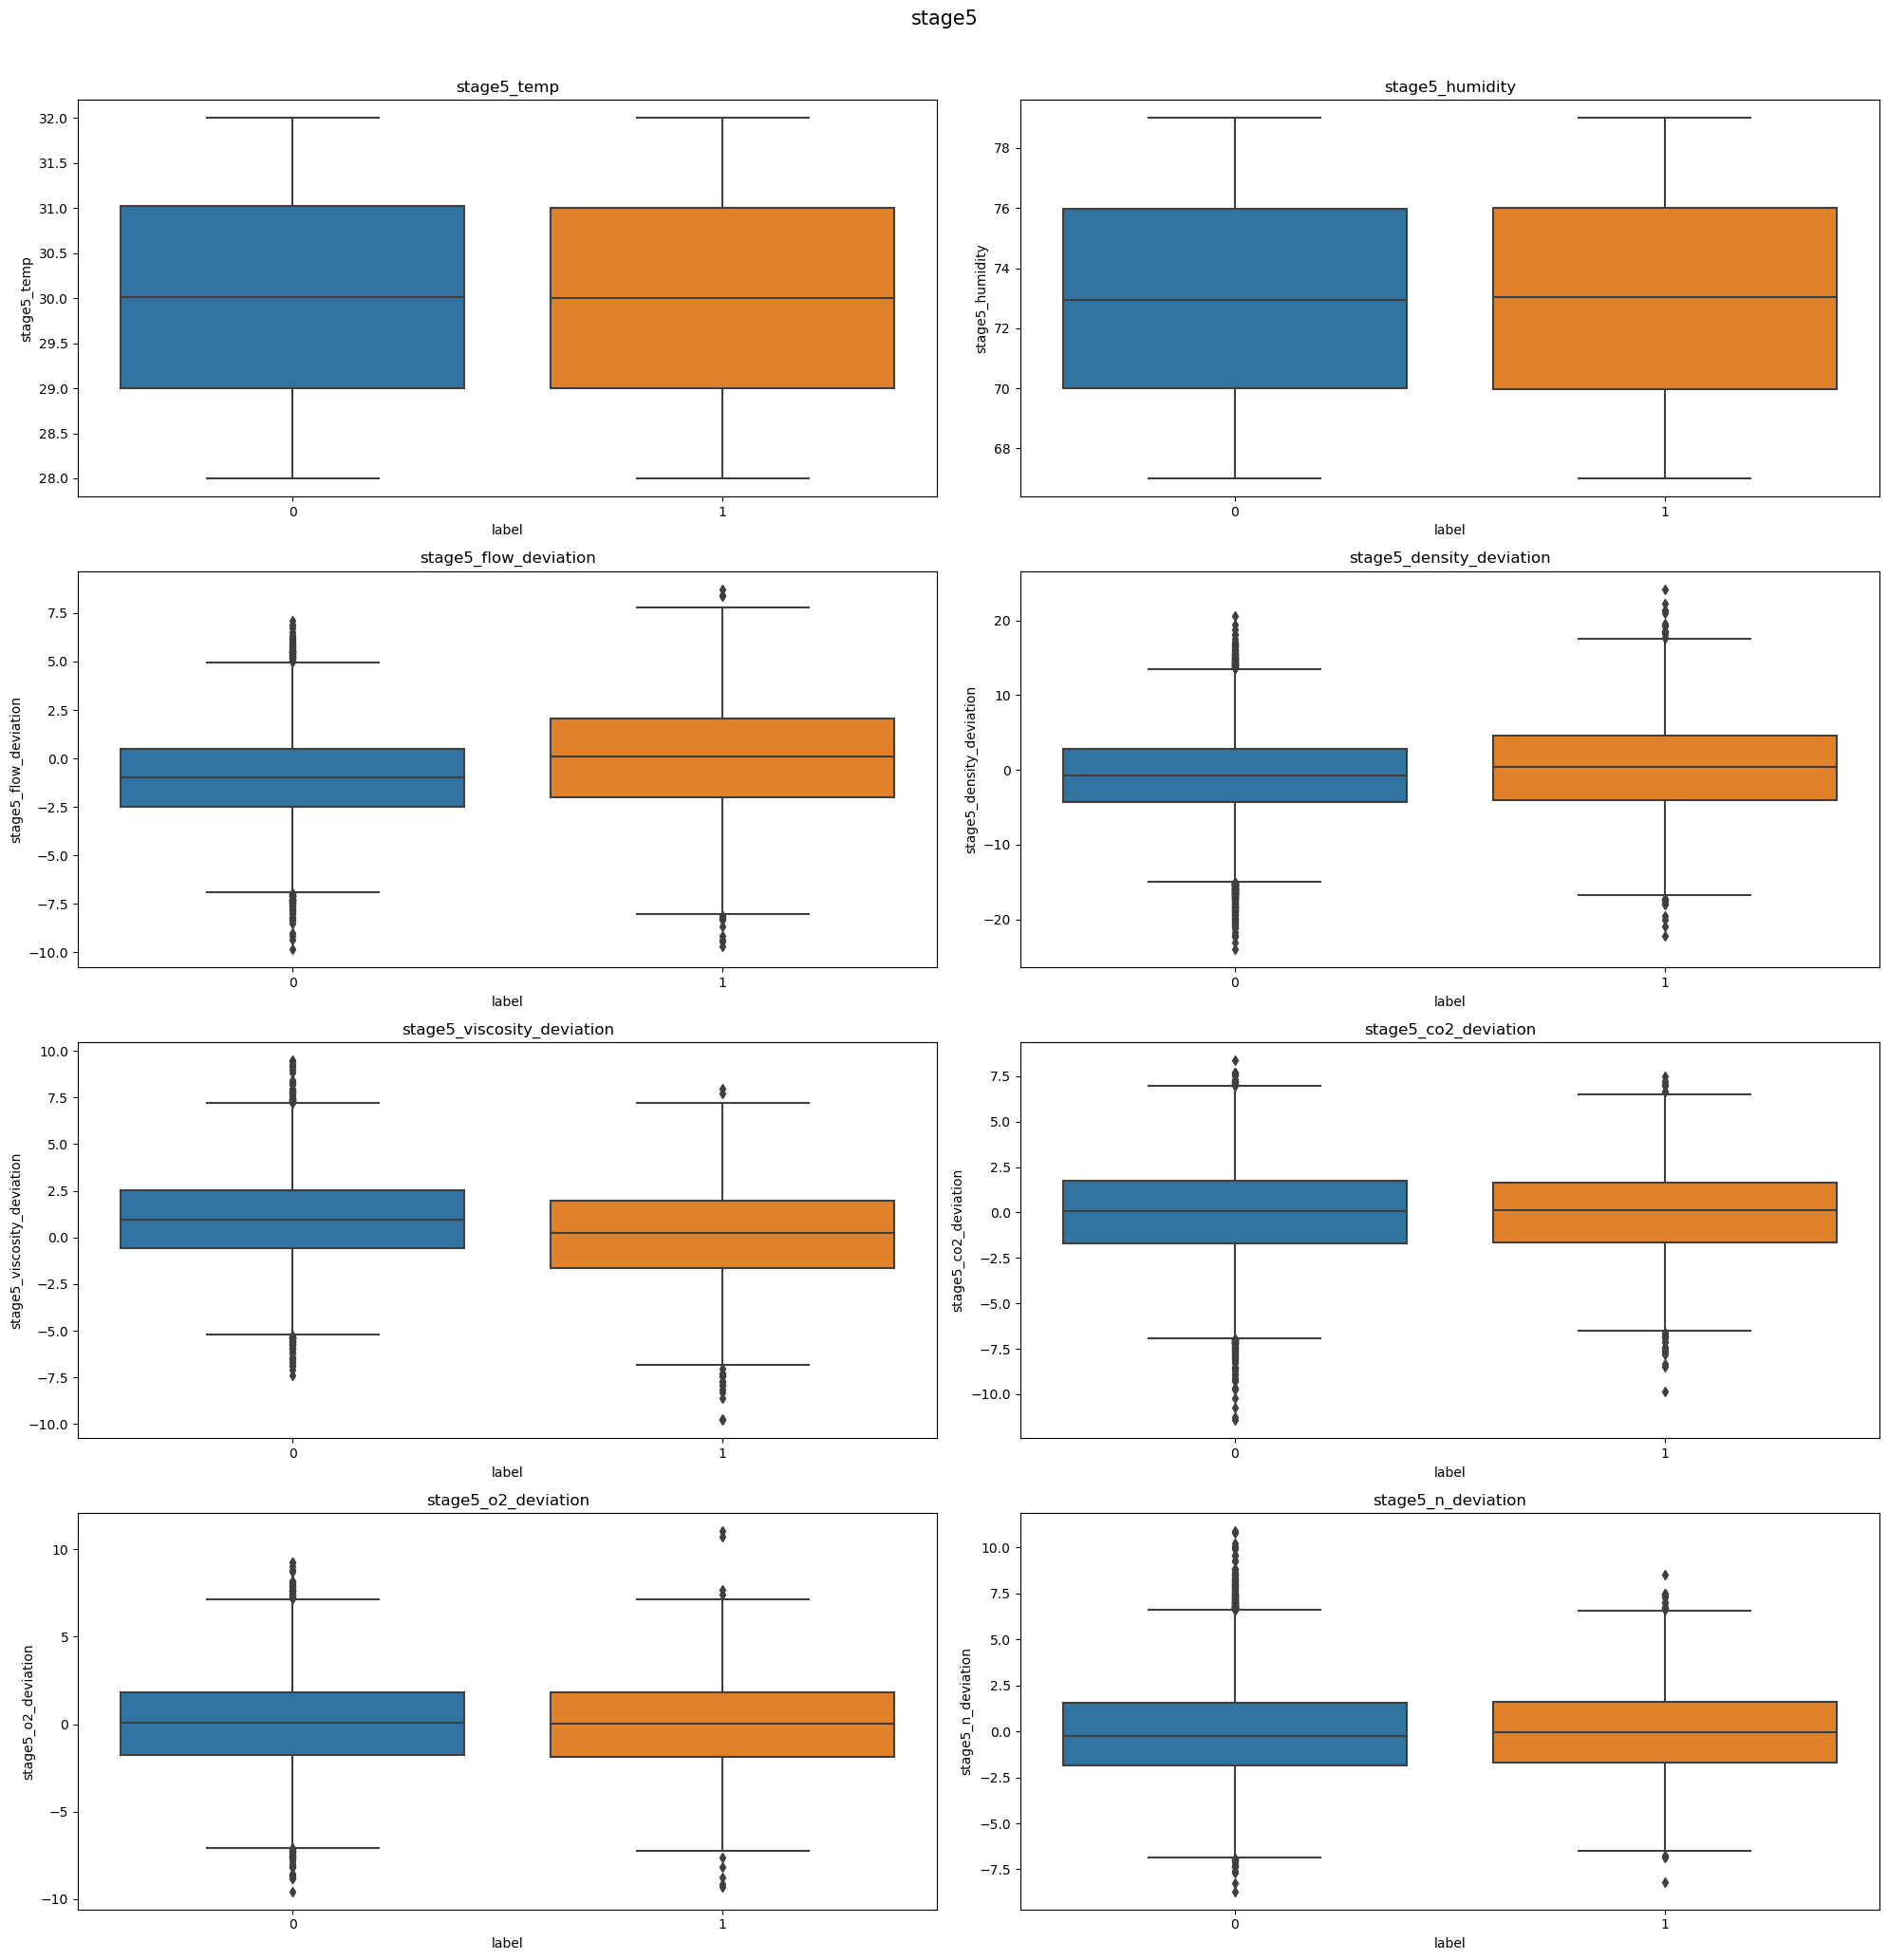

In [15]:
feature_boxplot(df, stage5_cols)

In [16]:
df['label'].value_counts(normalize=True)

0    0.7978
1    0.2022
Name: label, dtype: float64

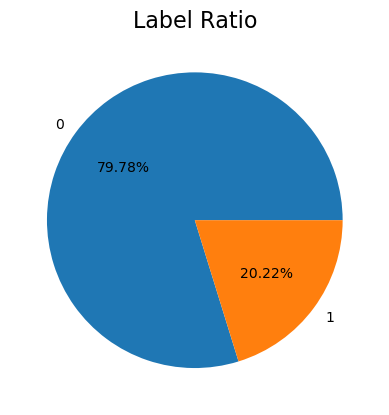

In [17]:
label_pct = df['label'].value_counts(normalize=True)

plt.pie(label_pct, labels=label_pct.index, autopct='%1.2f%%')
plt.title("Label Ratio", fontsize=16)

plt.show()

In [18]:
eda_results = pd.DataFrame()

eda_results["null_count"] = df.isnull().sum()
eda_results["null_pct"] = df.isnull().sum() / len(df)
eda_results["num_unique_values"] = df.nunique()

eda_results

,null_count,null_pct,num_unique_values
stage1_temp,0,0.000000,401
stage2_temp,0,0.000000,401
stage3_temp,0,0.000000,401
stage4_temp,0,0.000000,401
stage5_temp,0,0.000000,401
stage1_humidity,0,0.000000,1201
stage2_humidity,0,0.000000,1201
stage3_humidity,0,0.000000,1201
stage4_humidity,0,0.000000,1201
stage5_humidity,0,0.000000,1201


In [19]:
# 결측치 30% 이상인 feature 제거
df.drop(columns = df.columns[df.isnull().sum()/len(df) >= 0.3], axis = 1, inplace=True)

In [20]:
df[['stage1_temp', 'stage2_temp', 'stage3_temp', 'stage4_temp', 'stage5_temp']].describe()

,stage1_temp,stage2_temp,stage3_temp,stage4_temp,stage5_temp
count,16998.000000,16998.000000,16998.000000,16998.000000,16998.000000
mean,30.001594,29.990075,29.997045,30.001217,30.002879
std,1.147790,1.151904,1.158444,1.151763,1.160540
min,28.000000,28.000000,28.000000,28.000000,28.000000
25%,29.010000,28.980000,28.990000,29.020000,29.000000
50%,30.000000,30.000000,30.000000,29.990000,30.010000
75%,31.000000,30.990000,31.000000,30.990000,31.020000
max,32.000000,32.000000,32.000000,32.000000,32.000000


In [21]:
df[['stage1_humidity', 'stage2_humidity', 'stage3_humidity', 'stage4_humidity', 'stage5_humidity']].describe()

,stage1_humidity,stage2_humidity,stage3_humidity,stage4_humidity,stage5_humidity
count,16998.000000,16998.000000,16998.000000,16998.000000,16998.000000
mean,72.979076,72.992427,72.963232,73.043451,72.978755
std,3.468240,3.466325,3.471202,3.459762,3.468162
min,67.000000,67.000000,67.000000,67.000000,67.000000
25%,69.950000,69.990000,69.960000,70.100000,70.000000
50%,72.990000,72.970000,72.900000,73.040000,72.950000
75%,75.960000,75.990000,75.950000,76.030000,75.987500
max,79.000000,79.000000,79.000000,79.000000,79.000000


In [22]:
# 각 공정마다의 온도, 습도는 유의미한 차이가 없다는 도메인 전문가의 조언에 따라 평균값으로 컬럼 대체
# 각 공정마다의 온도, 습도를 2개의 feature로 축소
df.insert(0, 'stage_mean_temp', df[['stage1_temp', 'stage2_temp', 'stage3_temp', 'stage4_temp', 'stage5_temp']].mean(axis=1))
df.insert(1, 'stage_mean_humidity', df[['stage1_humidity', 'stage2_humidity', 'stage3_humidity', 'stage4_humidity', 'stage5_humidity']].mean(axis=1))

df.drop(
    labels=[
        'stage1_temp', 'stage2_temp', 'stage3_temp', 'stage4_temp', 'stage5_temp',
        'stage1_humidity', 'stage2_humidity', 'stage3_humidity', 'stage4_humidity', 'stage5_humidity'
    ], axis=1, inplace=True
)

In [23]:
df.shape

(16998, 28)

In [24]:
# 결측값 대치에 KNNImputer 사용
# 수치 데이터 및 센서 데이터 유형에 적합한 옵션
# 원하는 인접 이웃 수의 가중 평균을 사용하여 결측값을 대치

knn_imputer = KNNImputer(n_neighbors=10, weights='uniform', metric='nan_euclidean')
df_knn_imputed = pd.DataFrame(knn_imputer.fit_transform(df), columns=df.columns)

df_knn_imputed

,stage_mean_temp,stage_mean_humidity,stage1_density_deviation,stage1_viscosity_deviation,stage1_o2_deviation,stage1_n_deviation,stage2_flow_deviation,stage2_density_deviation,stage2_co2_deviation,stage2_o2_deviation,...,stage4_density_deviation,stage4_viscosity_deviation,stage4_co2_deviation,stage4_o2_deviation,stage4_n_deviation,stage5_flow_deviation,stage5_density_deviation,stage5_co2_deviation,stage5_o2_deviation,label
0,30.392,70.302,3.217163,5.716122,-1.830675,-0.229145,3.897850,-5.759907,1.292311,0.816498,...,-3.395391,3.897850,-0.381981,-0.917519,2.905965,1.112211,14.642069,2.249968,0.046280,1.0
1,30.834,72.420,2.899058,0.838872,0.179070,-0.678211,-0.336600,-0.030663,1.265400,-0.439536,...,-2.226715,-0.336600,10.276542,-4.937284,0.089265,-4.937284,12.361204,3.381750,5.827666,1.0
2,30.572,71.162,2.700569,1.686915,1.001300,-0.649136,5.108084,-9.791527,-1.287942,1.303298,...,-2.716912,5.108084,5.685728,-0.277344,0.871249,-0.955908,1.587669,-0.052572,-0.597566,0.0
3,30.130,71.016,0.326173,1.359592,0.743327,-0.809781,-2.535448,10.661374,-0.002497,1.111002,...,-1.126203,-2.535448,5.497906,-2.134062,-1.188985,-2.134062,2.149028,3.230979,-0.032255,0.0
4,29.406,74.144,4.694635,0.452394,-0.027711,-0.729316,-10.559326,-3.427760,0.855256,0.749749,...,-1.433270,-10.559326,7.259878,-0.192612,-1.648626,-0.192612,9.741397,-0.516248,2.129390,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16993,29.722,74.992,-0.362146,-0.896765,-0.854161,0.553653,2.143183,14.063821,3.598268,0.640966,...,0.318182,2.143183,-6.240376,-1.627189,-0.384339,-1.627189,-3.439305,2.343462,-0.342200,0.0
16994,29.246,71.286,0.814505,0.871520,0.114318,-0.656151,-1.132321,-4.847292,-1.172652,-0.170455,...,-0.677046,-1.132321,-1.139003,2.228396,-0.159255,2.228396,5.861357,-0.221628,-1.548085,1.0
16995,29.634,71.532,3.188329,-0.615150,1.976959,-0.226001,-3.958995,-2.603714,-1.124725,0.365687,...,1.878620,-3.958995,3.729189,-1.264070,0.124091,-0.859033,-0.722216,0.000299,-0.443228,0.0
16996,28.826,74.768,1.092366,-2.545665,0.097706,-0.637596,-5.690331,1.544018,1.127027,0.465569,...,-0.240304,-4.416355,-1.567624,-2.373612,-0.820434,-2.373612,-5.930715,-2.000998,4.125043,0.0


In [25]:
df_knn_imputed.isnull().sum()

stage_mean_temp               0
stage_mean_humidity           0
stage1_density_deviation      0
stage1_viscosity_deviation    0
stage1_o2_deviation           0
stage1_n_deviation            0
stage2_flow_deviation         0
stage2_density_deviation      0
stage2_co2_deviation          0
stage2_o2_deviation           0
stage2_n_deviation            0
stage3_flow_deviation         0
stage3_density_deviation      0
stage3_viscosity_deviation    0
stage3_co2_deviation          0
stage3_o2_deviation           0
stage3_n_deviation            0
stage4_flow_deviation         0
stage4_density_deviation      0
stage4_viscosity_deviation    0
stage4_co2_deviation          0
stage4_o2_deviation           0
stage4_n_deviation            0
stage5_flow_deviation         0
stage5_density_deviation      0
stage5_co2_deviation          0
stage5_o2_deviation           0
label                         0
dtype: int64

In [26]:
df_knn_imputed.columns[0: -1]

Index(['stage_mean_temp', 'stage_mean_humidity', 'stage1_density_deviation',
       'stage1_viscosity_deviation', 'stage1_o2_deviation',
       'stage1_n_deviation', 'stage2_flow_deviation',
       'stage2_density_deviation', 'stage2_co2_deviation',
       'stage2_o2_deviation', 'stage2_n_deviation', 'stage3_flow_deviation',
       'stage3_density_deviation', 'stage3_viscosity_deviation',
       'stage3_co2_deviation', 'stage3_o2_deviation', 'stage3_n_deviation',
       'stage4_flow_deviation', 'stage4_density_deviation',
       'stage4_viscosity_deviation', 'stage4_co2_deviation',
       'stage4_o2_deviation', 'stage4_n_deviation', 'stage5_flow_deviation',
       'stage5_density_deviation', 'stage5_co2_deviation',
       'stage5_o2_deviation'],
      dtype='object')

In [27]:
def feature_displot(df):
    fig = plt.figure()
    fig.set_size_inches(20, 20)

    for idx, col in enumerate(list(df)):
        plt.subplot(7, 4, idx+1)
        sns.distplot(df[col], kde=True)
        plt.axvline(df[col].mean(), color='blue', label='mean')
        plt.axvline(df[col].median(), color='red', label='median')
        plt.legend(loc='upper right')

    fig.suptitle("Feature Distribution Chart", fontsize=15, y=1.03)
    fig.tight_layout()

    plt.show()

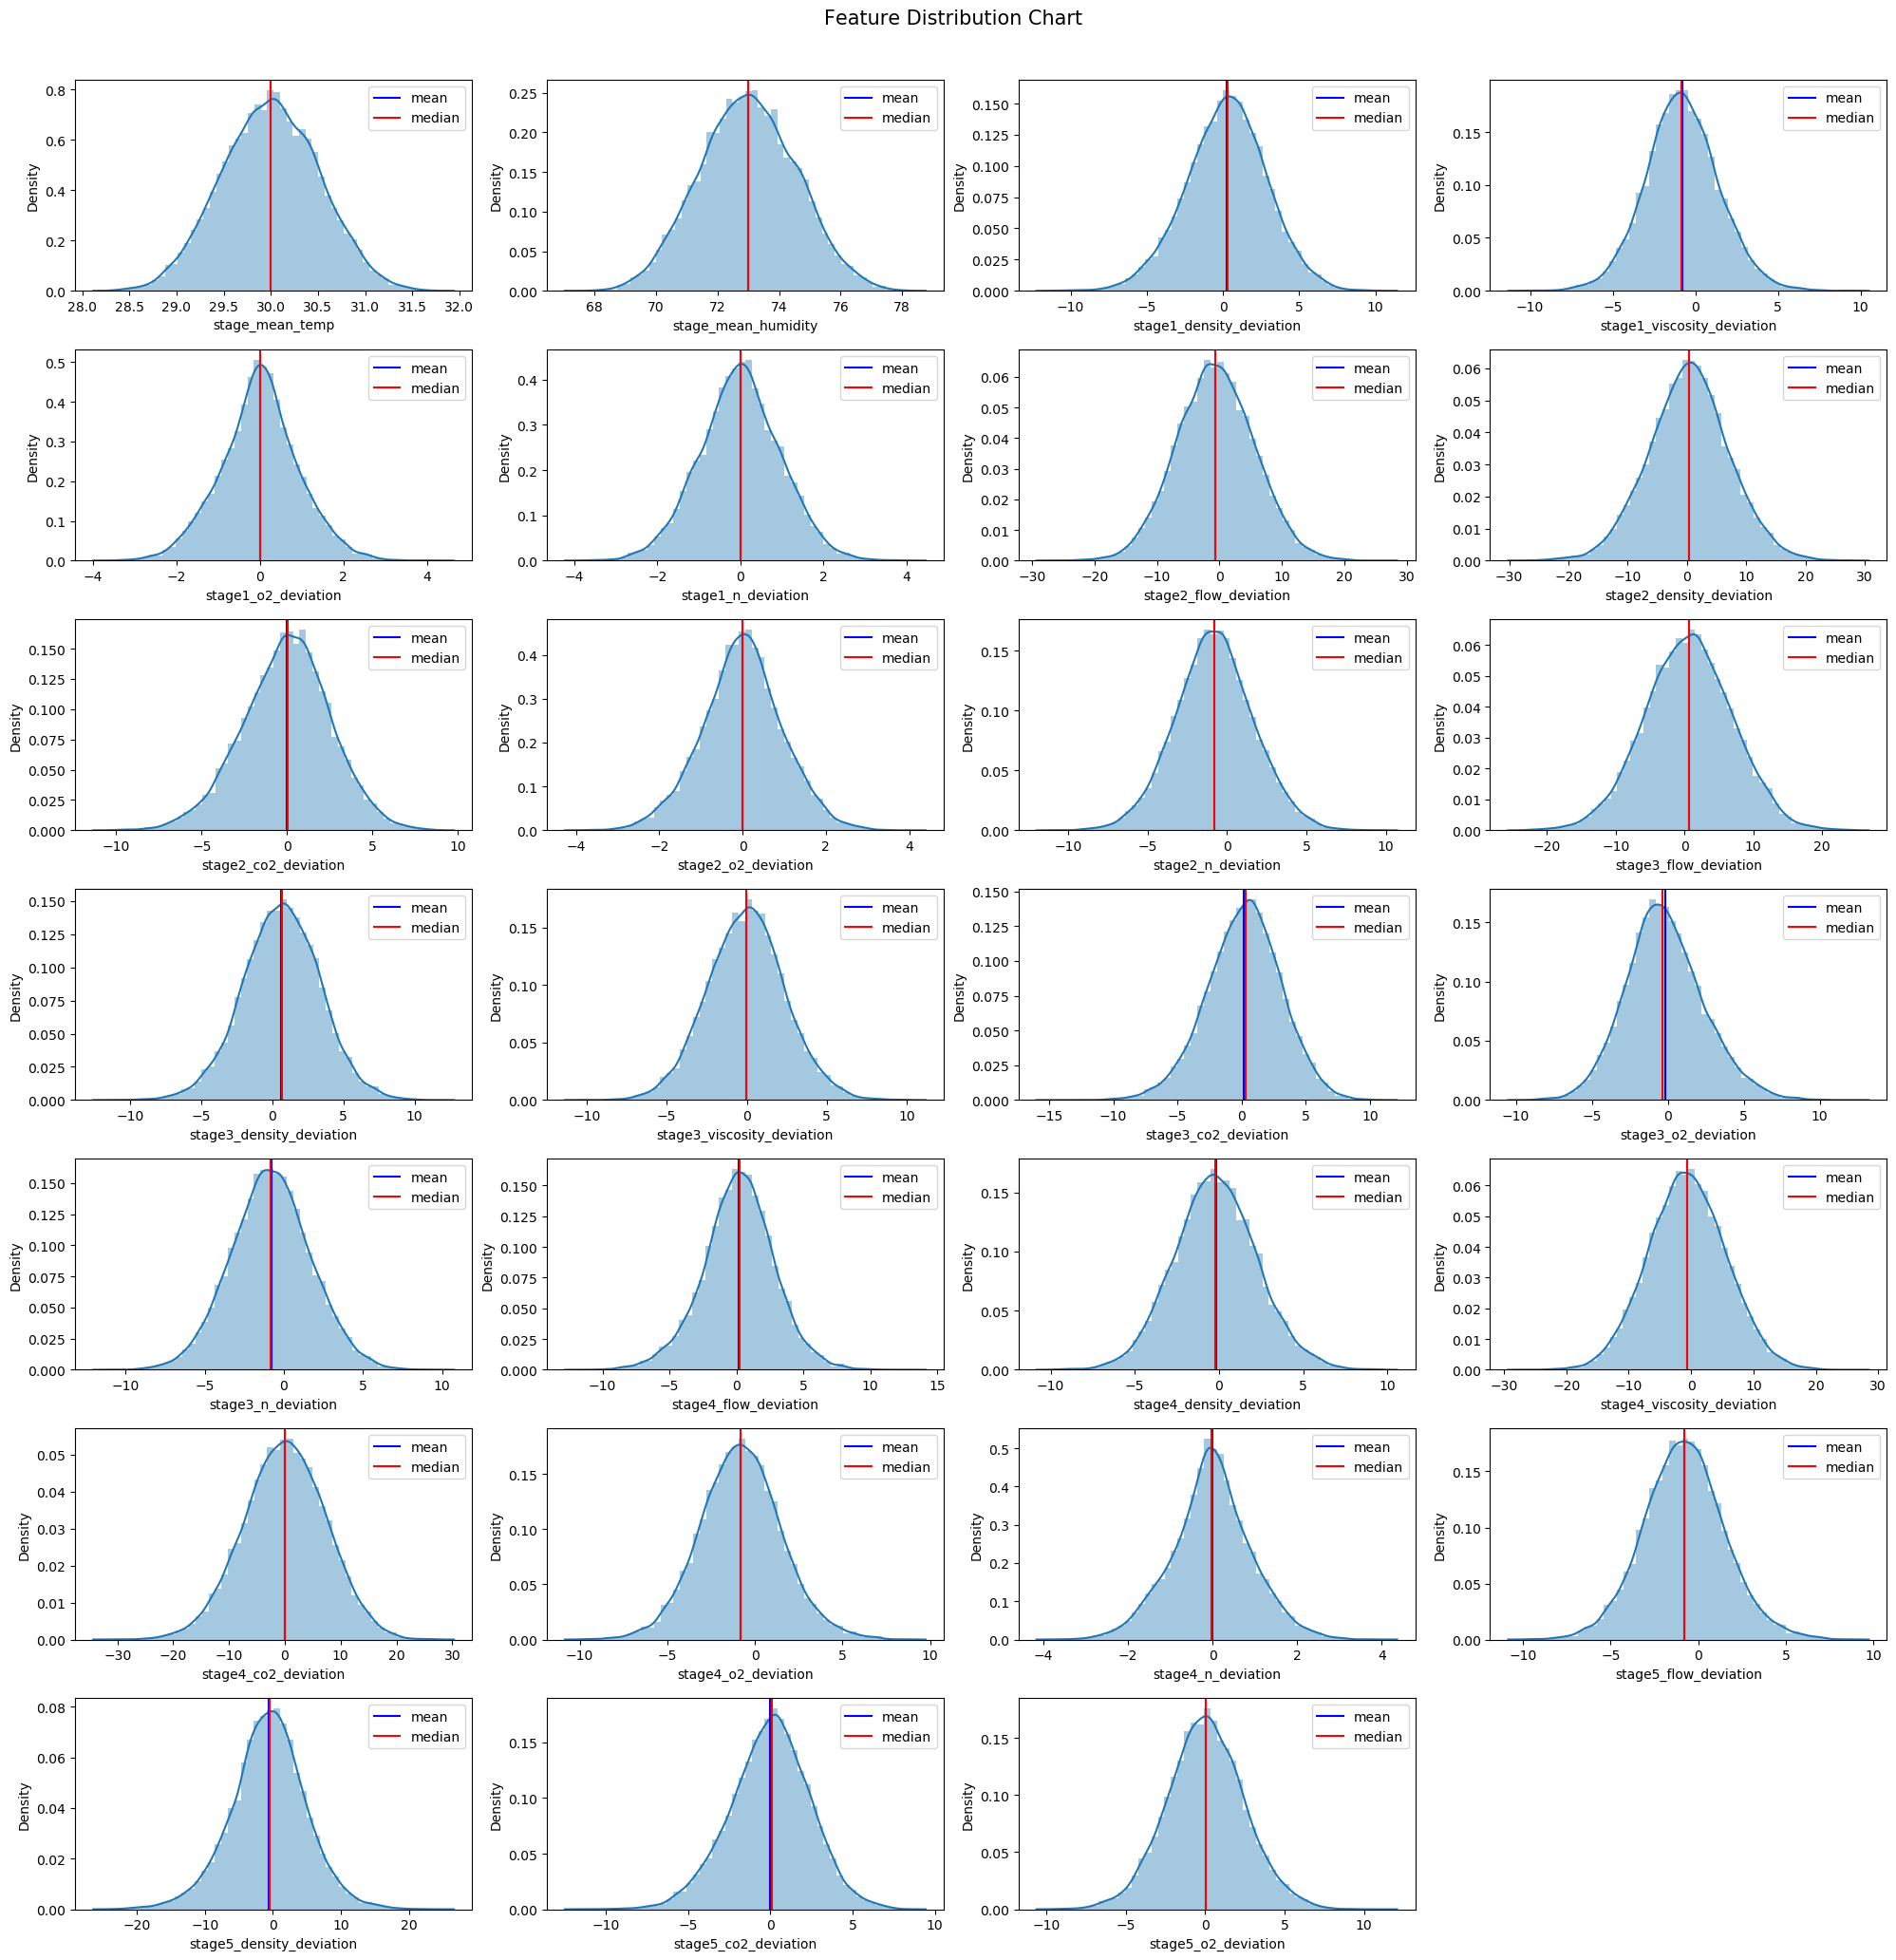

In [28]:
feature_displot(df_knn_imputed.iloc[:, 0:-1])

In [29]:
# def corrdot(*args, **kwargs):
#     temp2 = pd.DataFrame([args[0], args[1]]).T #두 컬럼을 dataframe화

#     #텍스트를 강조하기 위한 원 만들기
#     ax = plt.gca()
#     marker_size = 1500 #원 사이즈
#     corr_r = args[0].corr(args[1], 'pearson') #각 컬럼간 상관관계 구하기
#     ax.scatter([.85], [.85], marker_size, [corr_r], alpha=0.6, cmap="coolwarm",
#                vmin=-1, vmax=1, transform=ax.transAxes)
    
#     #원 안에 넣을 텍스트 만들기, corr 값 입력 및 두 컬럼 중 na가 하나라도 있는 것을 제외함
#     corr_text = f"{corr_r:2.2f}" + "\n" + "[" + str(temp2.dropna().shape[0]) + "]" 
    
#     #안에 넣을 텍스트를 삽입
#     font_size = 12
#     ax.annotate(corr_text, [.85, .85,], xycoords="axes fraction",
#                ha='center', va='center', fontsize=font_size)

In [30]:
# def hide_current_axis(*args, **kwds):
#     plt.gca().set_visible(False)

In [31]:
# with sns.plotting_context(rc={"axes.labelsize":15}):
#     # temp = data[['age','HR','war','YAB','YOPS']]
#     data = df_knn_imputed.iloc[:, 0:-1]

#     g = sns.PairGrid(data, diag_sharey=False)
#     g.fig.suptitle("pair plot 그리기", x=0.25, y=1.02, size=20)
    
#     g.map_lower(sns.scatterplot, data=data, alpha=0.5)
#     g.map_lower(sns.regplot, data=data, scatter=False, color=sns.color_palette("rocket")[3])
#     g.map_lower(corrdot)
    
#     g.map_upper(hide_current_axis)
    
#     g.map_diag(sns.distplot)

In [32]:
df_corr = df_knn_imputed.iloc[:, 0:-1].corr()

df_corr

,stage_mean_temp,stage_mean_humidity,stage1_density_deviation,stage1_viscosity_deviation,stage1_o2_deviation,stage1_n_deviation,stage2_flow_deviation,stage2_density_deviation,stage2_co2_deviation,stage2_o2_deviation,...,stage4_flow_deviation,stage4_density_deviation,stage4_viscosity_deviation,stage4_co2_deviation,stage4_o2_deviation,stage4_n_deviation,stage5_flow_deviation,stage5_density_deviation,stage5_co2_deviation,stage5_o2_deviation
stage_mean_temp,1.000000,0.001733,0.016468,0.010501,-0.011484,-0.007368,0.009665,-0.003822,-0.006157,-0.007012,...,0.007066,0.008557,0.012481,-0.004190,-0.000363,-0.004840,-0.000336,-0.009740,-0.002099,0.004685
stage_mean_humidity,0.001733,1.000000,-0.004575,-0.017979,0.000810,-0.004154,0.001455,0.020172,0.000868,0.000293,...,0.001977,0.006460,0.000732,-0.013343,0.012493,-0.004520,0.010959,-0.007253,-0.004621,-0.001089
stage1_density_deviation,0.016468,-0.004575,1.000000,0.116933,-0.006873,0.013074,0.145099,-0.315426,-0.336457,0.006278,...,0.093683,0.105282,0.144396,-0.030332,-0.057038,0.006181,-0.056651,0.110178,-0.225346,0.044549
stage1_viscosity_deviation,0.010501,-0.017979,0.116933,1.000000,-0.007146,-0.001344,0.135798,-0.389668,0.061979,0.008179,...,-0.038502,-0.190634,0.134883,0.117720,0.015184,0.011217,0.014362,0.305505,0.152838,0.112194
stage1_o2_deviation,-0.011484,0.000810,-0.006873,-0.007146,1.000000,-0.014808,0.002290,0.009459,-0.001267,-0.007723,...,-0.004631,0.009509,0.002725,-0.007308,0.002226,-0.000505,0.001895,-0.009820,0.004263,-0.003930
stage1_n_deviation,-0.007368,-0.004154,0.013074,-0.001344,-0.014808,1.000000,-0.012860,0.000581,-0.015019,-0.014581,...,-0.001212,0.008935,-0.014319,-0.008074,-0.004920,-0.014466,-0.002411,-0.010355,-0.019759,-0.010965
stage2_flow_deviation,0.009665,0.001455,0.145099,0.135798,0.002290,-0.012860,1.000000,-0.016146,0.181320,0.011581,...,0.068975,0.103713,0.994000,-0.398500,0.458987,0.000087,0.458101,0.149920,0.302865,-0.264213
stage2_density_deviation,-0.003822,0.020172,-0.315426,-0.389668,0.009459,0.000581,-0.016146,1.000000,0.379151,0.001748,...,0.201261,0.268064,-0.016190,-0.303046,0.188257,-0.006889,0.186070,-0.084175,0.076788,0.098026
stage2_co2_deviation,-0.006157,0.000868,-0.336457,0.061979,-0.001267,-0.015019,0.181320,0.379151,1.000000,0.003877,...,0.104034,-0.313329,0.180348,-0.186861,0.184029,0.006647,0.178575,0.297081,0.093780,0.279808
stage2_o2_deviation,-0.007012,0.000293,0.006278,0.008179,-0.007723,-0.014581,0.011581,0.001748,0.003877,1.000000,...,0.011846,0.002176,0.011177,-0.007122,0.006509,0.005177,0.004341,-0.001675,0.010869,-0.005875


26.5 0.5


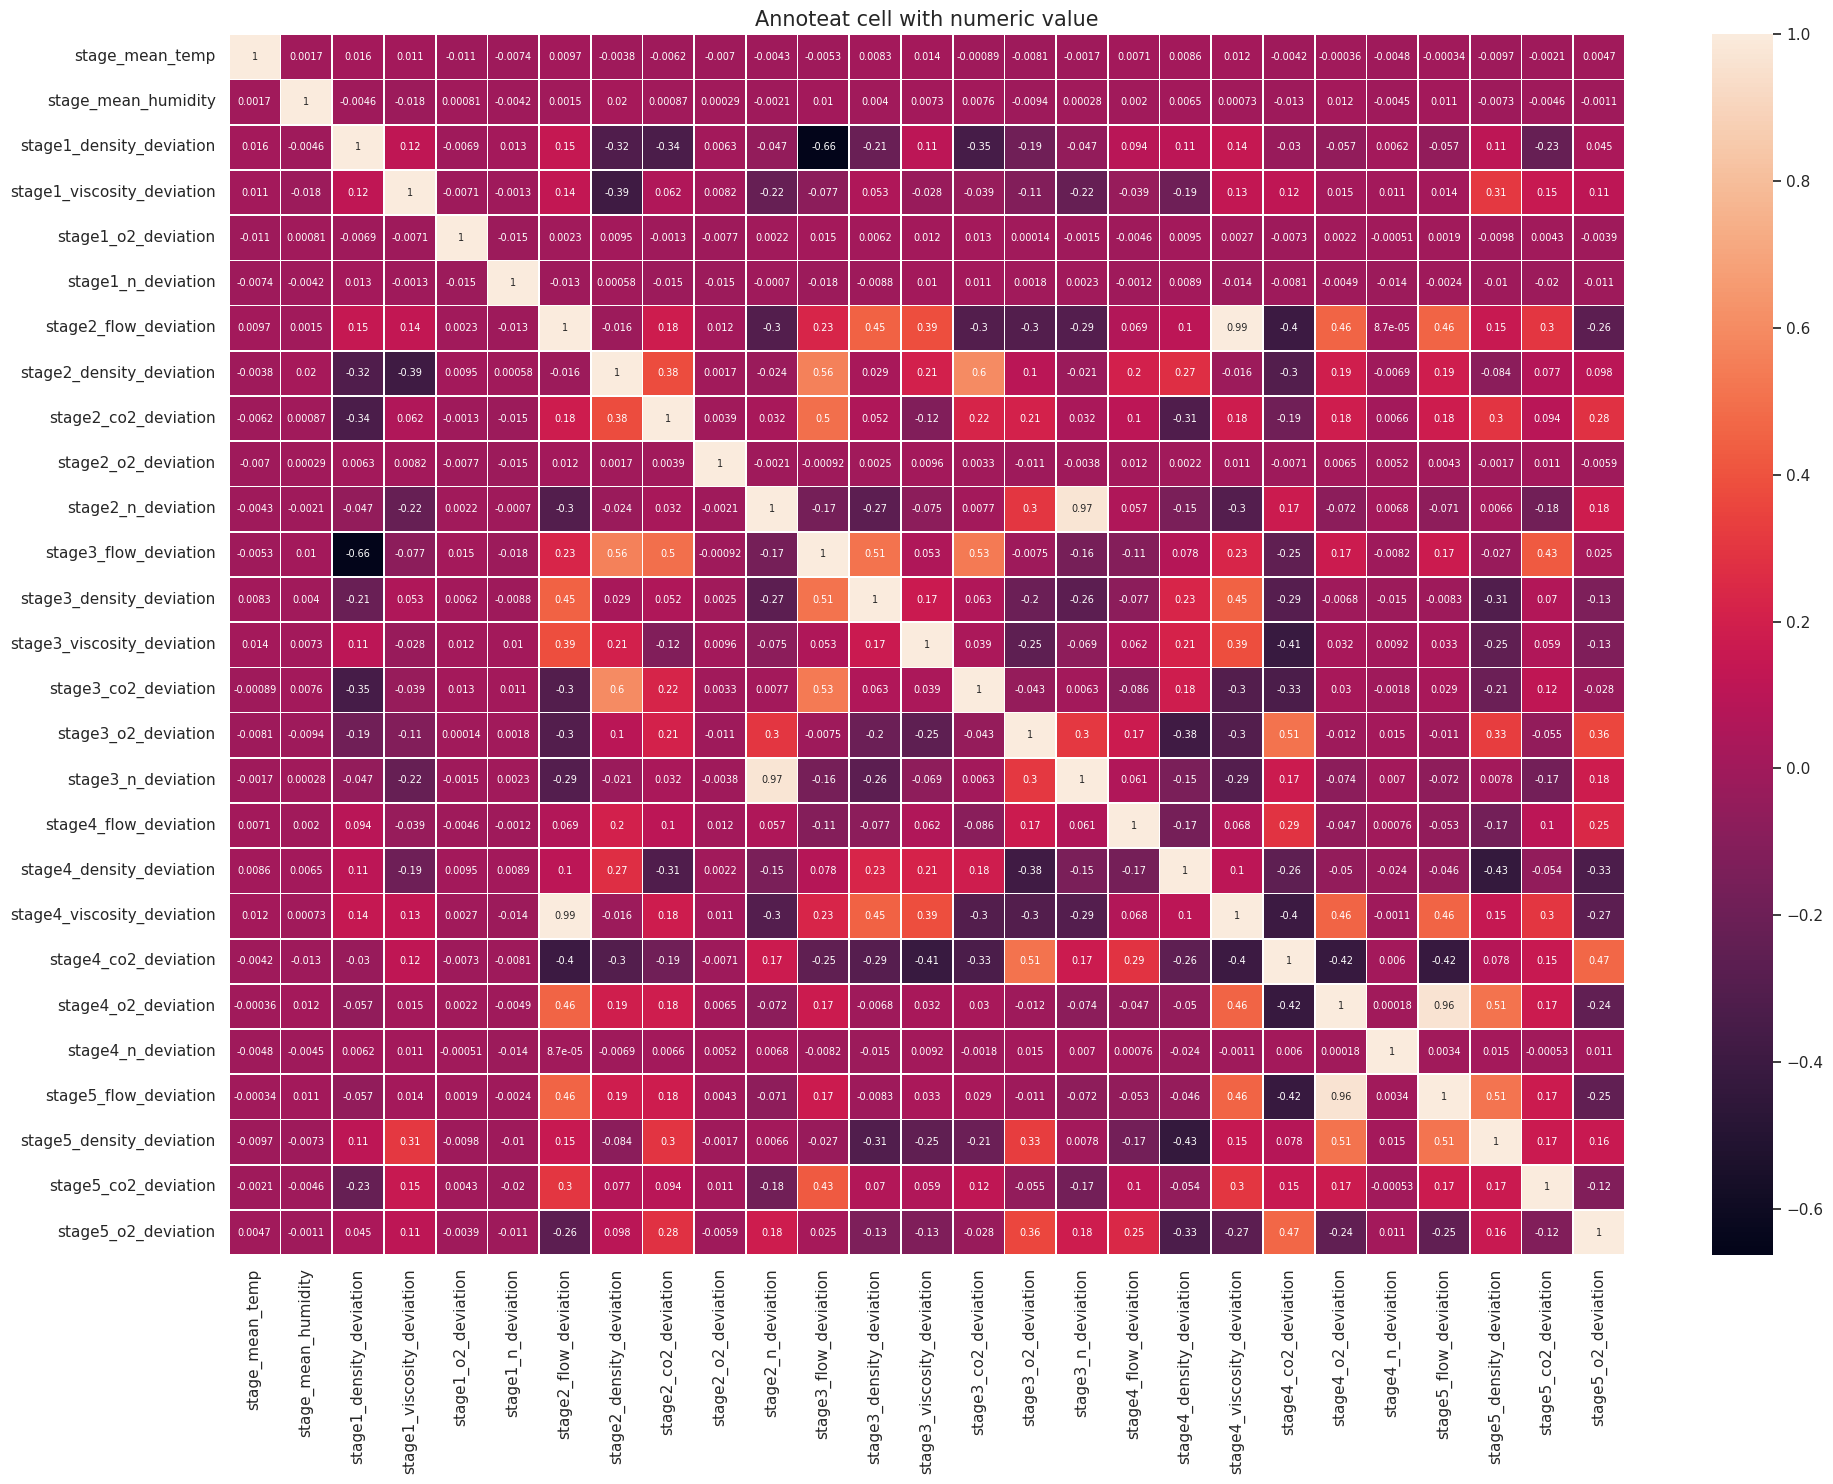

In [33]:
# annot=True argument를 써서 각 셀에 숫자를 입력(annotate each cell with numeric value)

sns.set(rc = {'figure.figsize':(20,15)})
corr_heatmap = sns.heatmap(df_corr, annot=True, linewidths=.5, annot_kws={"size": 7})
bottom, top = corr_heatmap.get_ylim() # heatmap의 현재 축을 확인
print(bottom, top)
corr_heatmap.set_ylim(bottom + 0.5, top - 0.5) # 잘린부분이 있으면 set_ylim() 으로 조정
plt.title('Annoteat cell with numeric value', fontsize=15, y=3)
plt.tight_layout()

plt.show()

In [34]:
# stage2_flow_deviation, stage2_n_deviation 컬럼 삭제 -> 상관관계가 높은 컬럼 제거
df_knn_imputed.drop(labels=['stage2_flow_deviation', 'stage2_n_deviation', 'stage4_o2_deviation'], axis=1, inplace=True)

In [35]:
df_corr_2 = df_knn_imputed.iloc[:, 0:-1].corr()

df_corr_2

,stage_mean_temp,stage_mean_humidity,stage1_density_deviation,stage1_viscosity_deviation,stage1_o2_deviation,stage1_n_deviation,stage2_density_deviation,stage2_co2_deviation,stage2_o2_deviation,stage3_flow_deviation,...,stage3_n_deviation,stage4_flow_deviation,stage4_density_deviation,stage4_viscosity_deviation,stage4_co2_deviation,stage4_n_deviation,stage5_flow_deviation,stage5_density_deviation,stage5_co2_deviation,stage5_o2_deviation
stage_mean_temp,1.000000,0.001733,0.016468,0.010501,-0.011484,-0.007368,-0.003822,-0.006157,-0.007012,-0.005323,...,-0.001670,0.007066,0.008557,0.012481,-0.004190,-0.004840,-0.000336,-0.009740,-0.002099,0.004685
stage_mean_humidity,0.001733,1.000000,-0.004575,-0.017979,0.000810,-0.004154,0.020172,0.000868,0.000293,0.009991,...,0.000280,0.001977,0.006460,0.000732,-0.013343,-0.004520,0.010959,-0.007253,-0.004621,-0.001089
stage1_density_deviation,0.016468,-0.004575,1.000000,0.116933,-0.006873,0.013074,-0.315426,-0.336457,0.006278,-0.663344,...,-0.047094,0.093683,0.105282,0.144396,-0.030332,0.006181,-0.056651,0.110178,-0.225346,0.044549
stage1_viscosity_deviation,0.010501,-0.017979,0.116933,1.000000,-0.007146,-0.001344,-0.389668,0.061979,0.008179,-0.077264,...,-0.222639,-0.038502,-0.190634,0.134883,0.117720,0.011217,0.014362,0.305505,0.152838,0.112194
stage1_o2_deviation,-0.011484,0.000810,-0.006873,-0.007146,1.000000,-0.014808,0.009459,-0.001267,-0.007723,0.015159,...,-0.001486,-0.004631,0.009509,0.002725,-0.007308,-0.000505,0.001895,-0.009820,0.004263,-0.003930
stage1_n_deviation,-0.007368,-0.004154,0.013074,-0.001344,-0.014808,1.000000,0.000581,-0.015019,-0.014581,-0.017672,...,0.002277,-0.001212,0.008935,-0.014319,-0.008074,-0.014466,-0.002411,-0.010355,-0.019759,-0.010965
stage2_density_deviation,-0.003822,0.020172,-0.315426,-0.389668,0.009459,0.000581,1.000000,0.379151,0.001748,0.559995,...,-0.020685,0.201261,0.268064,-0.016190,-0.303046,-0.006889,0.186070,-0.084175,0.076788,0.098026
stage2_co2_deviation,-0.006157,0.000868,-0.336457,0.061979,-0.001267,-0.015019,0.379151,1.000000,0.003877,0.498959,...,0.032471,0.104034,-0.313329,0.180348,-0.186861,0.006647,0.178575,0.297081,0.093780,0.279808
stage2_o2_deviation,-0.007012,0.000293,0.006278,0.008179,-0.007723,-0.014581,0.001748,0.003877,1.000000,-0.000919,...,-0.003774,0.011846,0.002176,0.011177,-0.007122,0.005177,0.004341,-0.001675,0.010869,-0.005875
stage3_flow_deviation,-0.005323,0.009991,-0.663344,-0.077264,0.015159,-0.017672,0.559995,0.498959,-0.000919,1.000000,...,-0.161478,-0.108861,0.077922,0.227555,-0.249652,-0.008174,0.171216,-0.027075,0.425241,0.025150


23.5 0.5


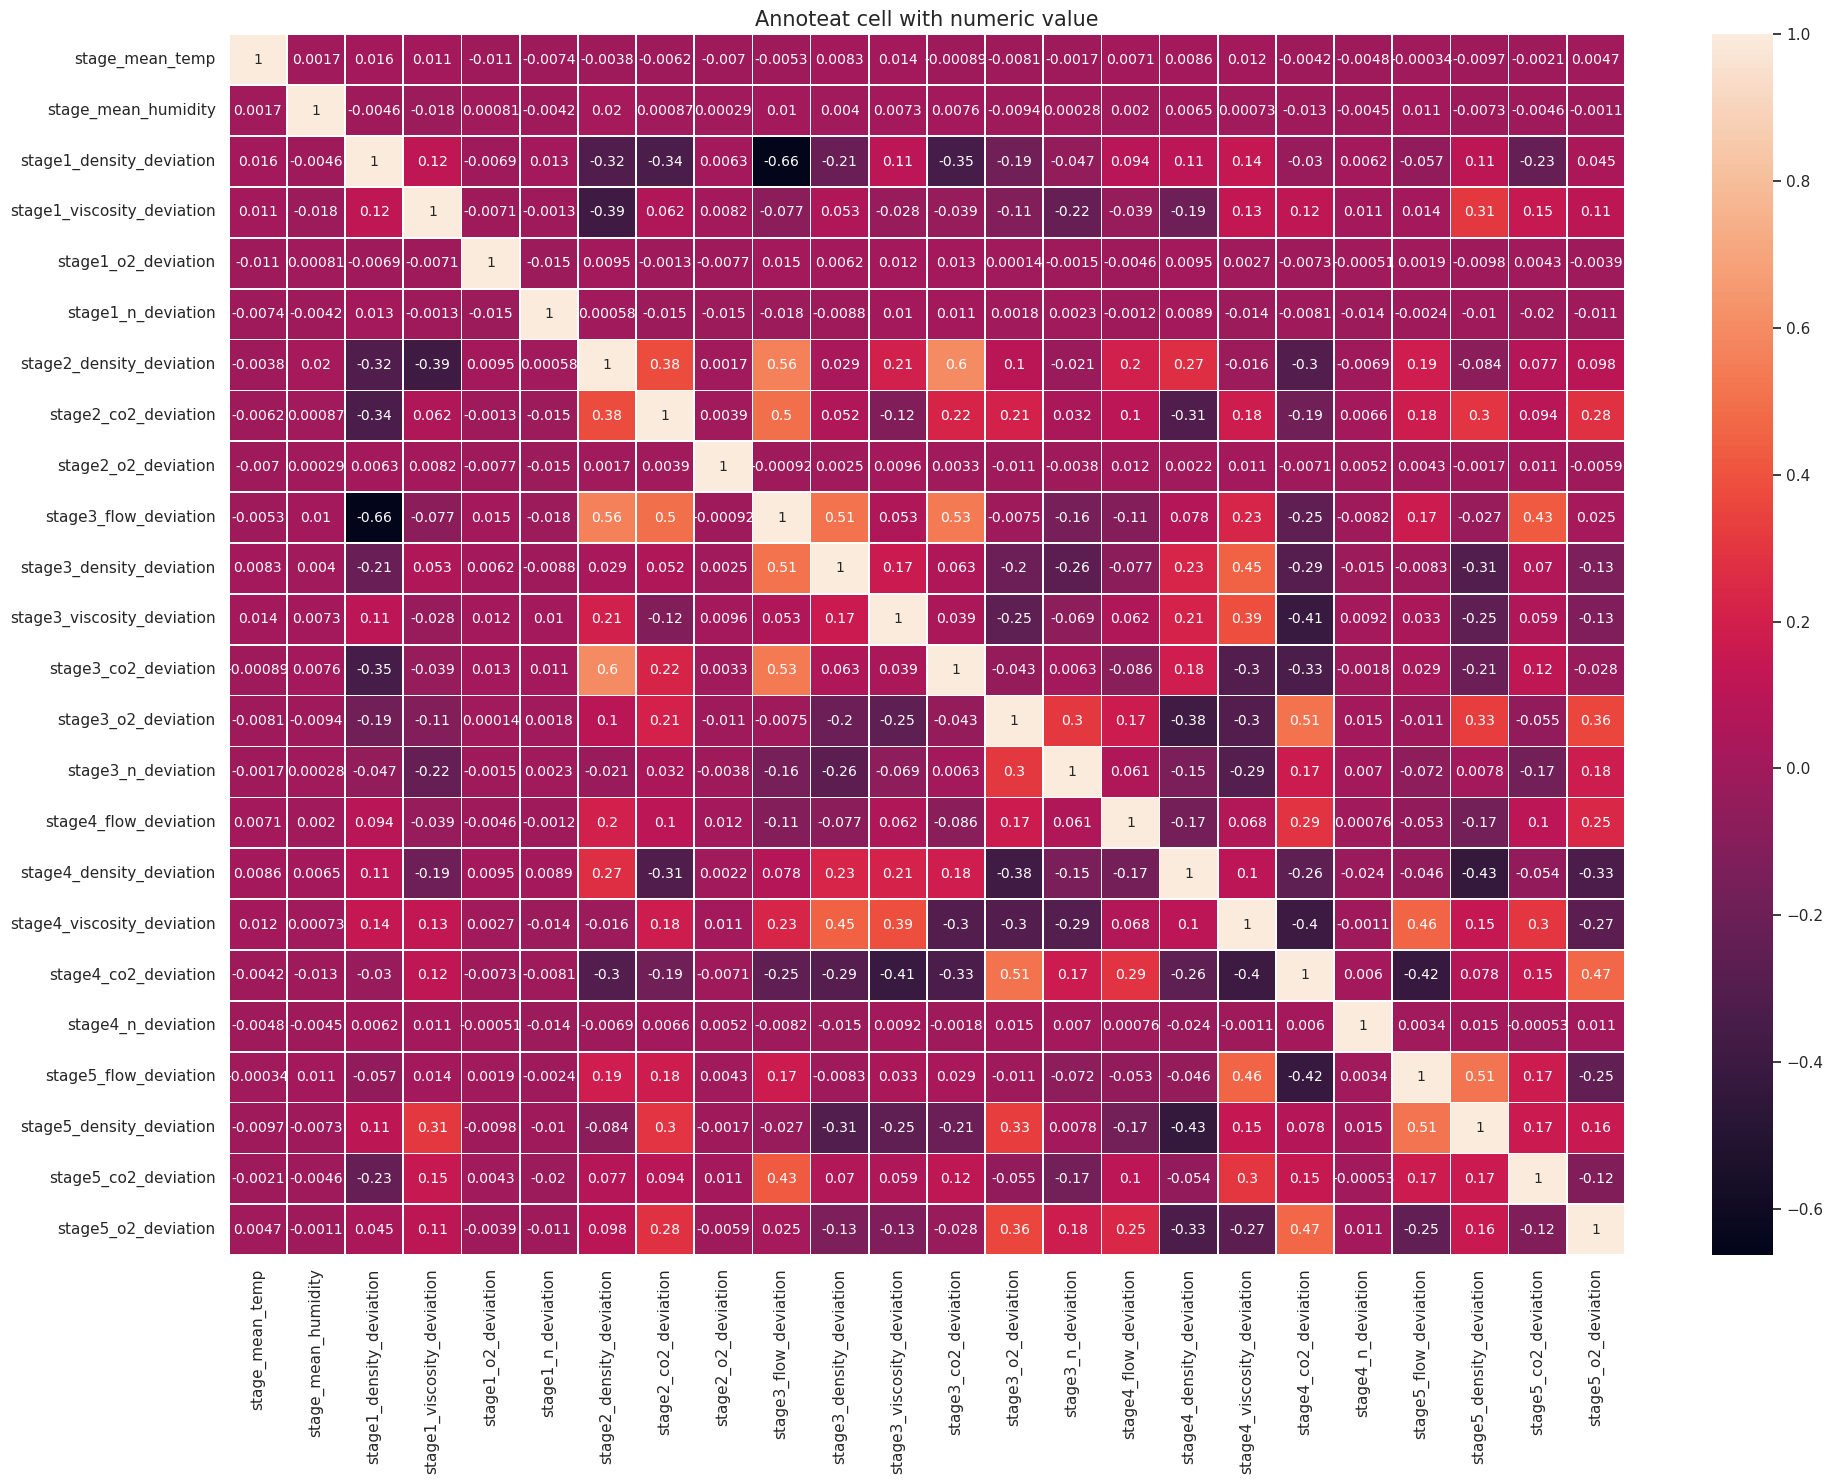

In [36]:
sns.set(rc = {'figure.figsize':(20,15)})
corr_2_heatmap = sns.heatmap(df_corr_2, annot=True, linewidths=.5, annot_kws={"size": 10})
bottom, top = corr_2_heatmap.get_ylim() # heatmap의 현재 축을 확인
print(bottom, top)
corr_2_heatmap.set_ylim(bottom + 0.5, top - 0.5) # 잘린부분이 있으면 set_ylim() 으로 조정
plt.title('Annoteat cell with numeric value', fontsize=15, y=3)
plt.tight_layout()

plt.show()

In [37]:
target = 'label'
x = df_knn_imputed.drop(target, axis = 1)
y = df_knn_imputed.loc[:,target]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, stratify=df_knn_imputed[target], random_state = 20)

In [38]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((13598, 24), (13598,), (3400, 24), (3400,))

In [39]:
y_train.value_counts(normalize=True)

0.0    0.797764
1.0    0.202236
Name: label, dtype: float64

In [40]:
y_test.value_counts(normalize=True)

0.0    0.797941
1.0    0.202059
Name: label, dtype: float64

In [41]:
# 제조업에서 불량 데이터는 적고 정상 데이터는 많기 때문에 데이터 불균형이 발생함.
# 제조업에서는 정상제품을 불량이라고 잘못 판단하는 것 보다 불량제품을 정상제품이라고 잘못 판단하는 것이 더 리스크가 큼
# 그러므로 Oversampling의 SMOTE 기법을 사용하여 데이터 불균형 해소
X_train_sampled, y_train_sampled = SMOTE(random_state=20).fit_resample(
    x_train, y_train
)

In [42]:
X_train_sampled.shape, y_train_sampled.shape, x_test.shape, y_test.shape

((21696, 24), (21696,), (3400, 24), (3400,))

In [43]:
y_train_sampled.value_counts(normalize=True)

1.0    0.5
0.0    0.5
Name: label, dtype: float64

In [44]:
# minmax_scaler = MinMaxScaler()
# x_train_minmax_s = minmax_scaler.fit_transform(X_train_sampled)
# x_test_minmax_s = minmax_scaler.transform(x_test)

In [45]:
# rfc_model = RandomForestClassifier()
# rfc_model.fit(x_train_minmax_s, y_train)

In [46]:
# rfc_pred = rfc_model.predict(x_test_minmax_s)
# print(confusion_matrix(y_test, rfc_pred))
# print(classification_report(y_test, rfc_pred))

In [47]:
# log_model = LogisticRegression()
# log_model.fit(x_train_minmax_s, y_train)

In [48]:
# log_pred = log_model.predict(x_test_minmax_s)
# print(confusion_matrix(y_test, log_pred))
# print(classification_report(y_test, log_pred))

In [49]:
# xgb_model = XGBClassifier(
#     objective="binary:logistic",
#     eval_metric="auc",
#     max_depth=6,
#     learning_rate=0.3,
#     n_estimators=1000,
#     random_state=20,
#     n_jobs=-1,
# )
# # xgb_model.fit(x_train_minmax_s, y_train_sampled)

In [50]:
def fit(X_train, y_train):
    xgb_model = XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        max_depth=6,
        learning_rate=0.3,
        n_estimators=1000,
        random_state=20,
        n_jobs=-1,
    )

    # params = {
    #     "learning_rate": [0.05, 0.1, 0.3],
    #     "n_estimators": [200, 500, 1000],
    #     "min_child_weight": [1, 3, 5],
    #     "max_depth": [6, 8, 10]
    # }

    params = {
        "learning_rate": [0.05],
        "n_estimators": [1000],
        "min_child_weight": [1],
        "max_depth": [10]
    }

    clf = RandomizedSearchCV(
        xgb_model,
        param_distributions=params,
        n_iter=10,
        cv=3,
        scoring="roc_auc",
        verbose=1,
        n_jobs=-1
    )

    clf.fit(X_train, y_train)
    print("Optimal Hyperparameter:", clf.best_params_)
    print("AUC:", clf.best_score_)

    return clf


def predict(X, y, best_estimator):
    threshold = 0.5

    y_pred_proba = best_estimator.predict_proba(X)[:, 1] # 1의 클래스에 속할 확률 리스트로 출력

    cm = confusion_matrix(y, y_pred_proba > threshold)
    report = classification_report(y, y_pred_proba > threshold) # 1의 클래스에 속할 확률이 threshold = 0.5 보다 크면 1로 반환 작으면 0으로 반환
    return y_pred_proba, cm, report

In [51]:
clf = fit(X_train_sampled, y_train_sampled)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Optimal Hyperparameter: {'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 10, 'learning_rate': 0.05}
AUC: 0.993591542811203


In [52]:
# best params : {'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 10, 'learning_rate': 0.05}
# xgb_model = XGBClassifier(
#         objective="binary:logistic",
#         eval_metric="auc",
#         max_depth=10,
#         min_child_weight=1,
#         learning_rate=0.05,
#         n_estimators=1000,
#         random_state=20,
#         n_jobs=-1,
#     )

In [53]:
def plot_confusion_matrix(X, y, best_estimator):
    plt.style.use('default') # plot 스타일 초기화

    disp = ConfusionMatrixDisplay.from_estimator(best_estimator, X, y, display_labels=['normal', 'abnormal'], cmap=plt.cm.Blues)
    fig = disp.figure_
    fig.set_size_inches(6, 6)
    fig.suptitle('Confusion matrix', fontsize=15)

    plt.show()

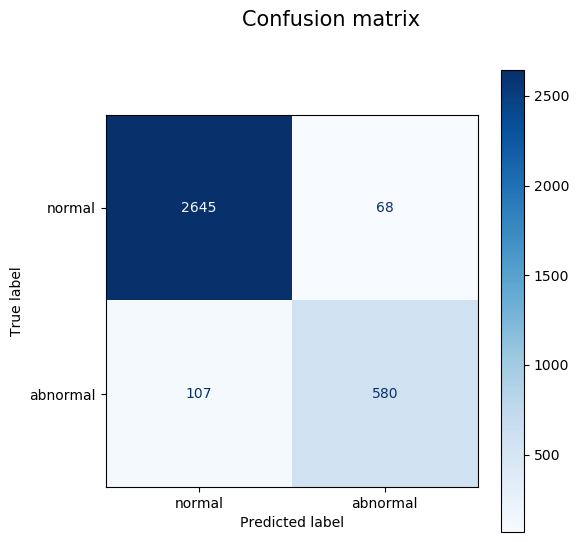

In [54]:
plot_confusion_matrix(x_test, y_test, clf.best_estimator_)

[[2645   68]
 [ 107  580]]
              precision    recall  f1-score   support

         0.0       0.96      0.97      0.97      2713
         1.0       0.90      0.84      0.87       687

    accuracy                           0.95      3400
   macro avg       0.93      0.91      0.92      3400
weighted avg       0.95      0.95      0.95      3400



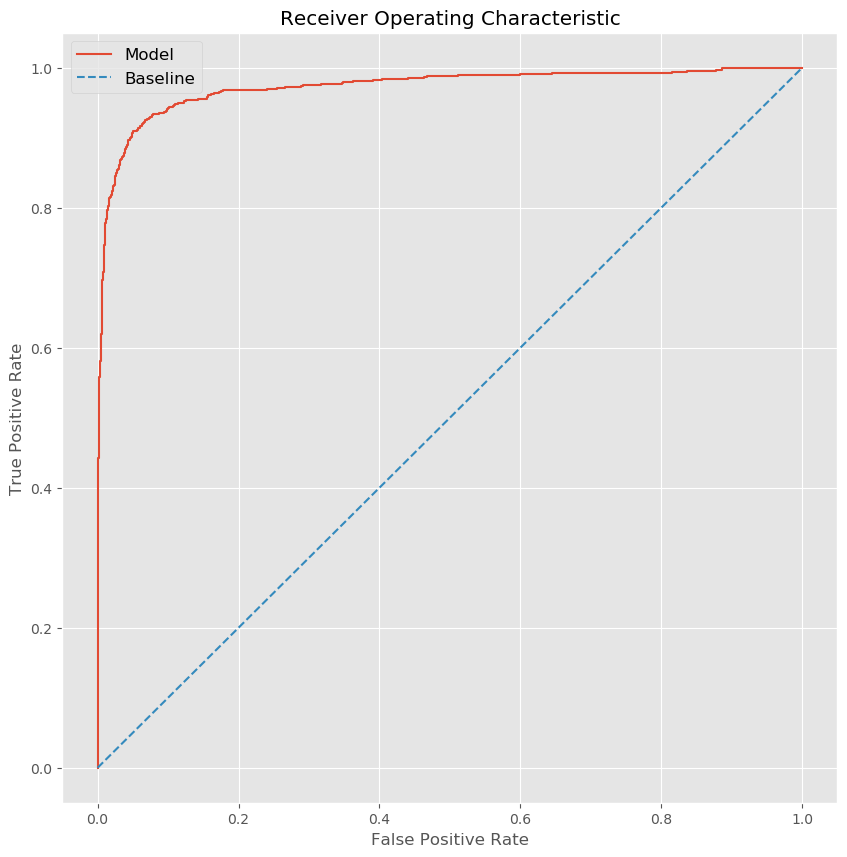

In [55]:
def plot_roc(y, y_pred_proba):
    auc_score = roc_auc_score(y, y_pred_proba)
    fpr, tpr, _ = roc_curve(y, y_pred_proba)
    baseline_fpr, baseline_tpr, _ = roc_curve(y, [0] * len(y))

    fig = plt.figure()
    fig.set_size_inches(10, 10)
    plt.style.use("ggplot")
    plt.plot(fpr, tpr, label="Model")
    plt.plot(baseline_fpr, baseline_tpr, linestyle="--", label="Baseline")
    plt.xlabel("False Positive Rate", size=12)
    plt.ylabel("True Positive Rate", size=12)
    plt.title("Receiver Operating Characteristic")
    plt.legend(prop={"size": 12})
    plt.show()
    return auc_score


y_test_pred_proba, cm, report = predict(x_test, y_test, clf.best_estimator_)
print(cm)
print(report)
auc_score = plot_roc(y_test, y_test_pred_proba)

In [56]:
print("Test AUC:", auc_score)

Test AUC: 0.9724390247828265


In [57]:
# 변수 중요도 plot
def plot_feature_importance(importance, names, topn = 'all'):

    # 변수 중요도와 변수 이름을 정렬해서 df로 저장
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    # 변수가 너무 많으면 보기 어려우니, top N 지정
    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    # 그래프 그리기
    plt.figure(figsize=(10,8))
    sns.barplot(x='feature_importance', y='feature_names', data = fi_df)
    plt.xlabel('importance')
    plt.ylabel('feature names')
    plt.grid()

    # 저장한 변수 중요도 df 반환
    return fi_df

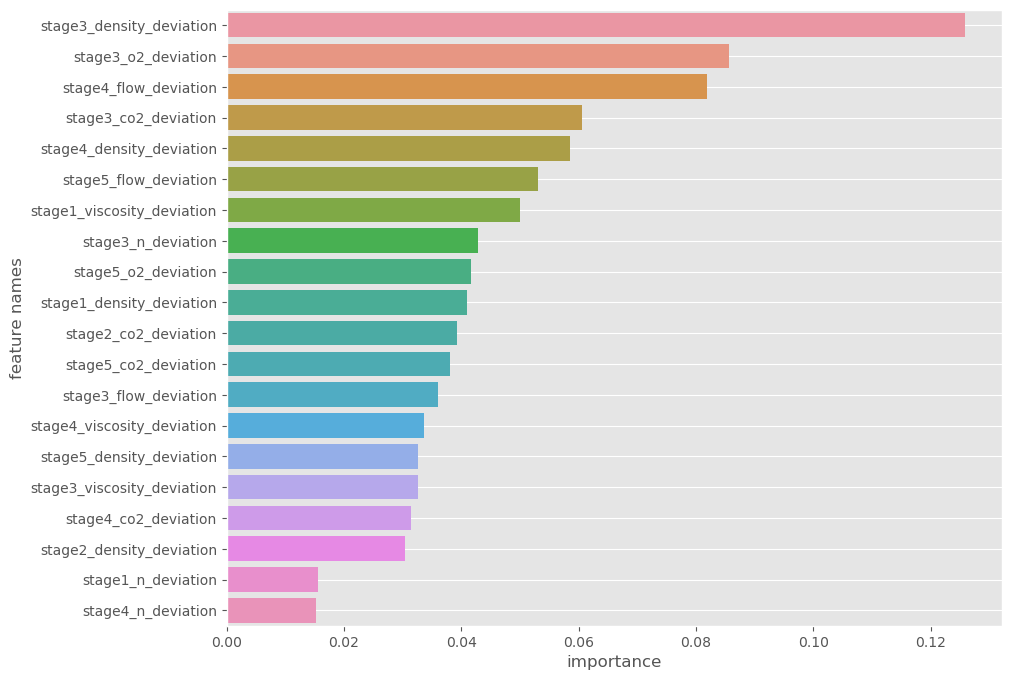

In [58]:
r2 = plot_feature_importance(clf.best_estimator_.feature_importances_, list(x_test), 20)

In [59]:
# permuter 정의
permuter = PermutationImportance(
    clf.best_estimator_,  # model
    scoring="accuracy",  # metric
    n_iter=10,  # 다른 random seed를 사용하여 10번 반복
    random_state=20,
)

permuter.fit(x_test, y_test)

PermutationImportance(estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                              callbacks=None,
                                              colsample_bylevel=1,
                                              colsample_bynode=1,
                                              colsample_bytree=1,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='auc',
                                              feature_types=None, gamma=0,
                                              gpu_id=-1,
                                              grow_policy='depthwise',
                                              importance_type=None,
                                              interaction_constraints='',
                                              learning_rate=0.05, max_bin=256,
                        

Text(0.5, 1.0, 'Permutation Importance')

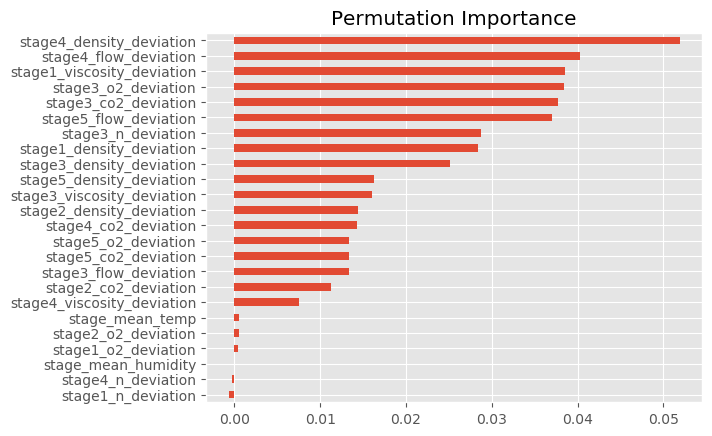

In [60]:
feature_names = x_test.columns.tolist()
pi = pd.Series(permuter.feature_importances_, feature_names).sort_values()
pi.plot.barh()
plt.title("Permutation Importance")

In [61]:
# df_x_test_minmax_s = pd.DataFrame(x_test, columns=x_test.columns, index=list(x_test.index.values))
# df_x_test_minmax_s

In [62]:
def plot_feature_pdp(feature, dataset, model):
    feature = feature

    isolated = pdp_isolate(
        model = model,
        dataset = dataset,
        model_features = dataset.columns,
        feature = feature,
        grid_type = "percentile",  # default = 'percentile', or 'equal'
        num_grid_points = 10  # default = 10
    )

    pdp_plot(isolated, feature_name=feature)

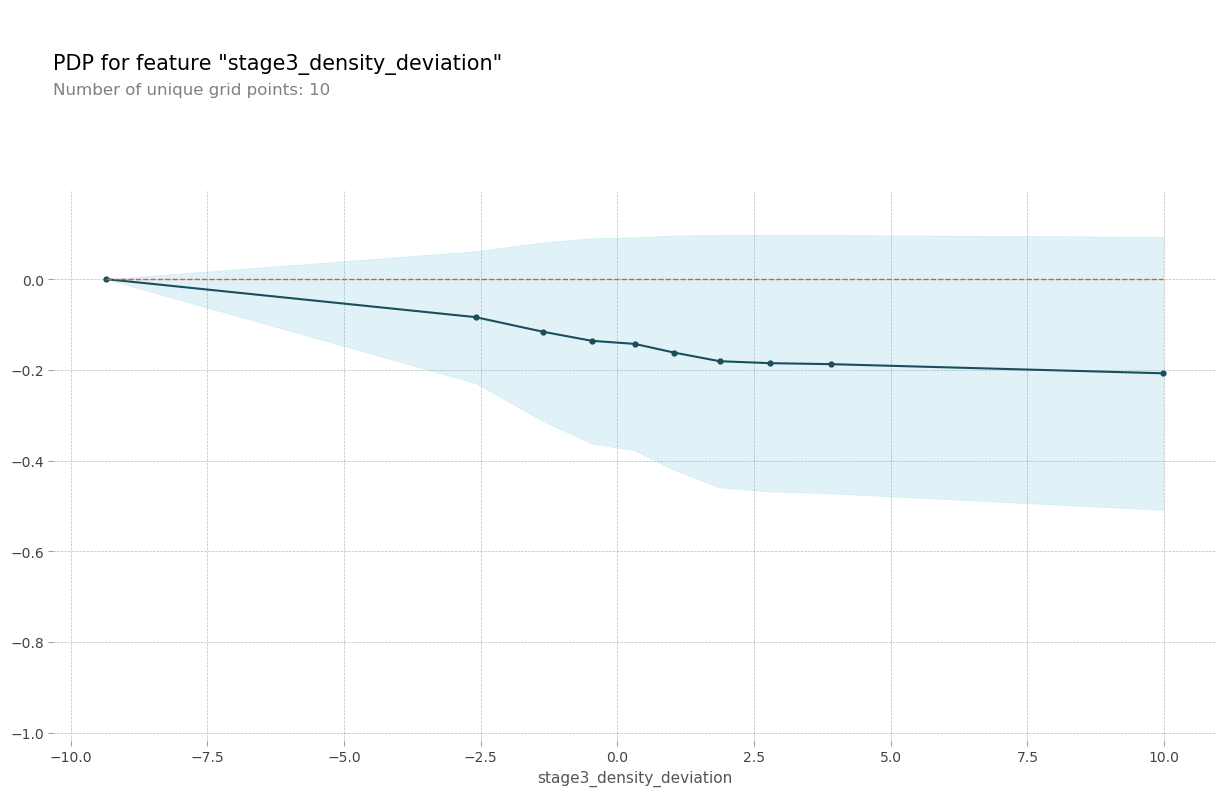

In [63]:
feature = "stage3_density_deviation"

plot_feature_pdp(feature, x_test, clf.best_estimator_)

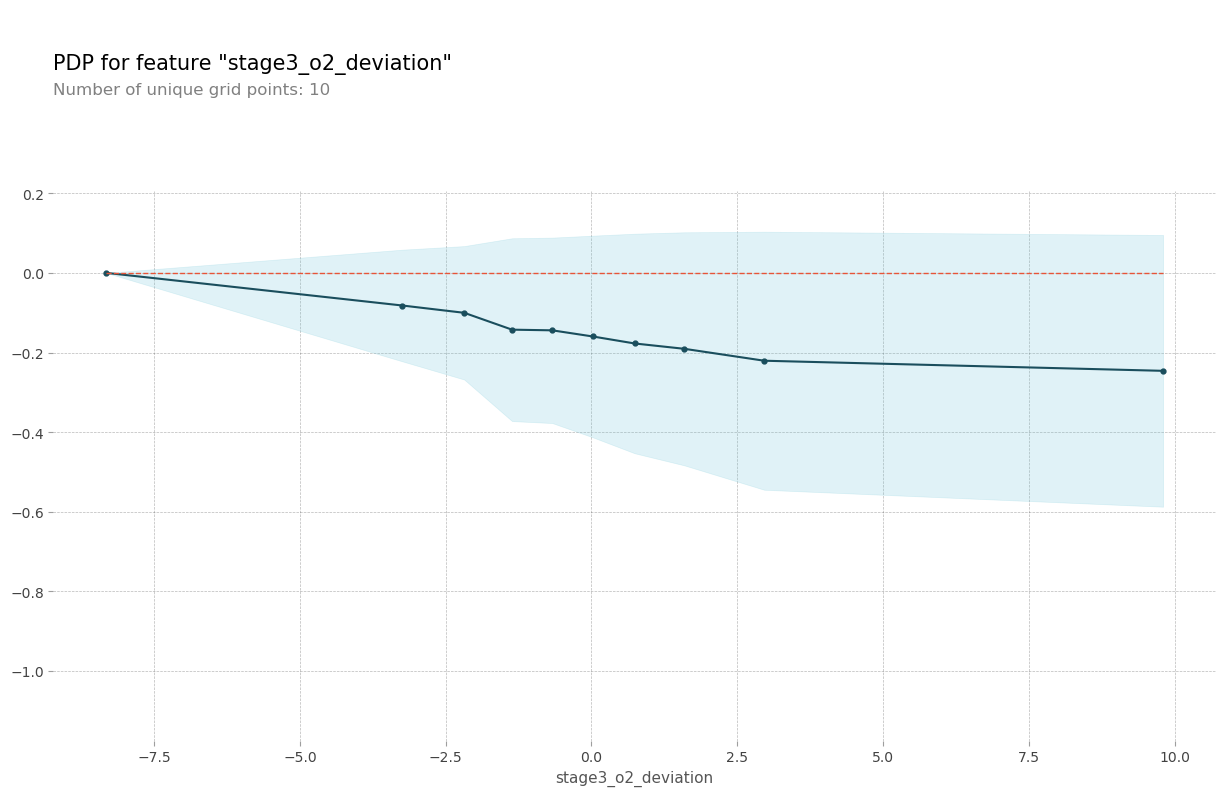

In [64]:
feature = "stage3_o2_deviation"

plot_feature_pdp(feature, x_test, clf.best_estimator_)

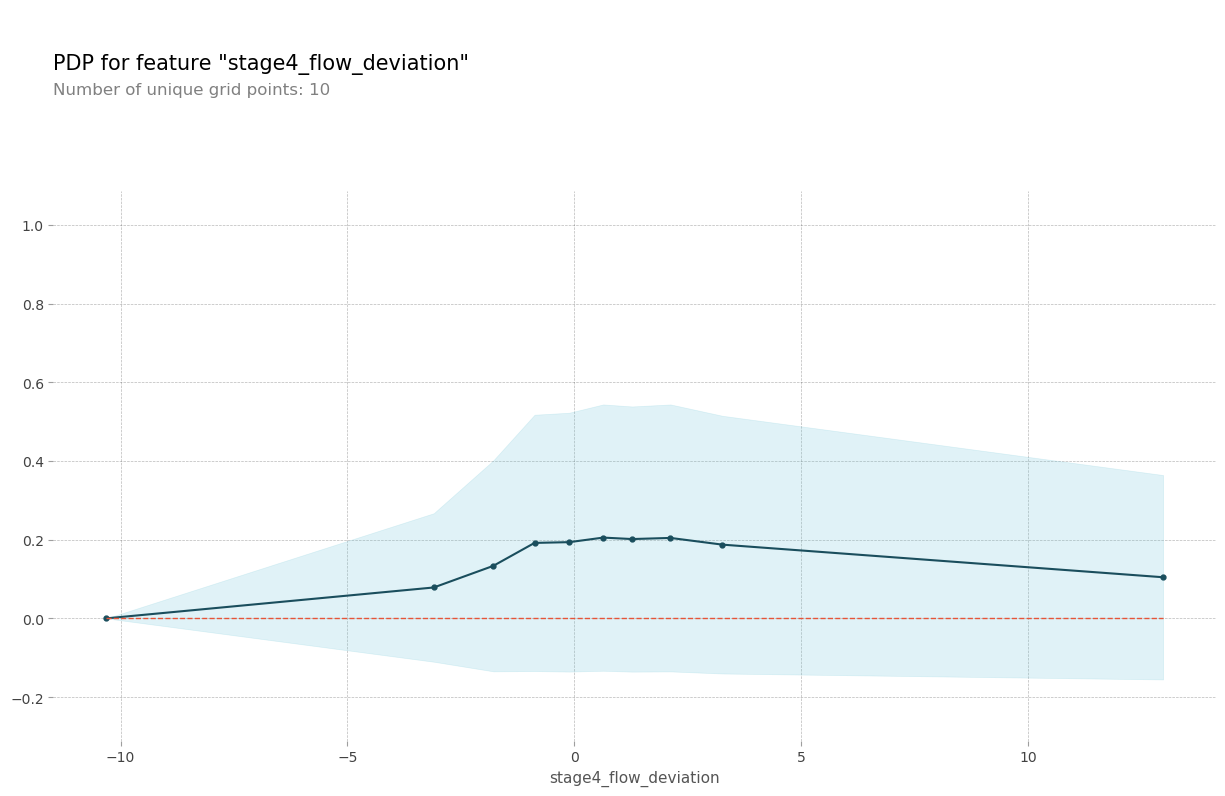

In [65]:
feature = "stage4_flow_deviation"

plot_feature_pdp(feature, x_test, clf.best_estimator_)

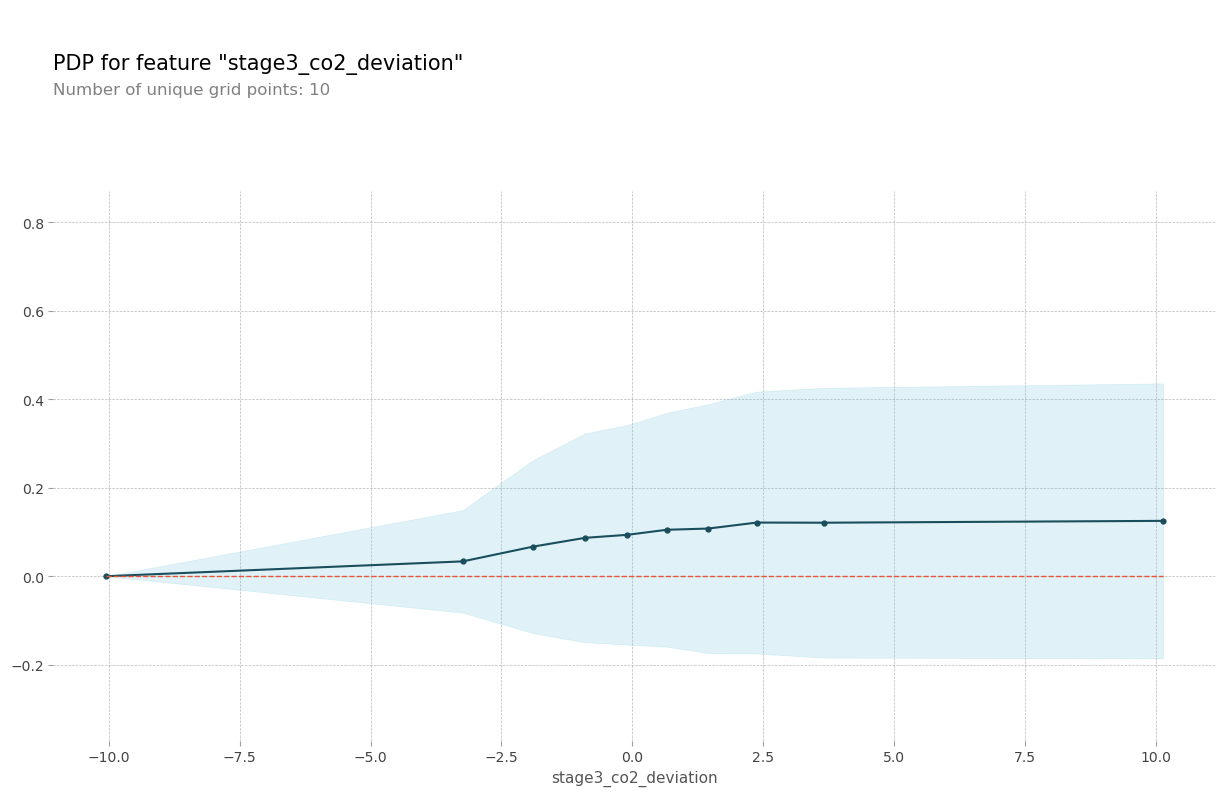

In [66]:
feature = "stage3_co2_deviation"

plot_feature_pdp(feature, x_test, clf.best_estimator_)

(<Figure size 750x950 with 3 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fcf902e8880>,
  'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fcef7b9a2e0>})

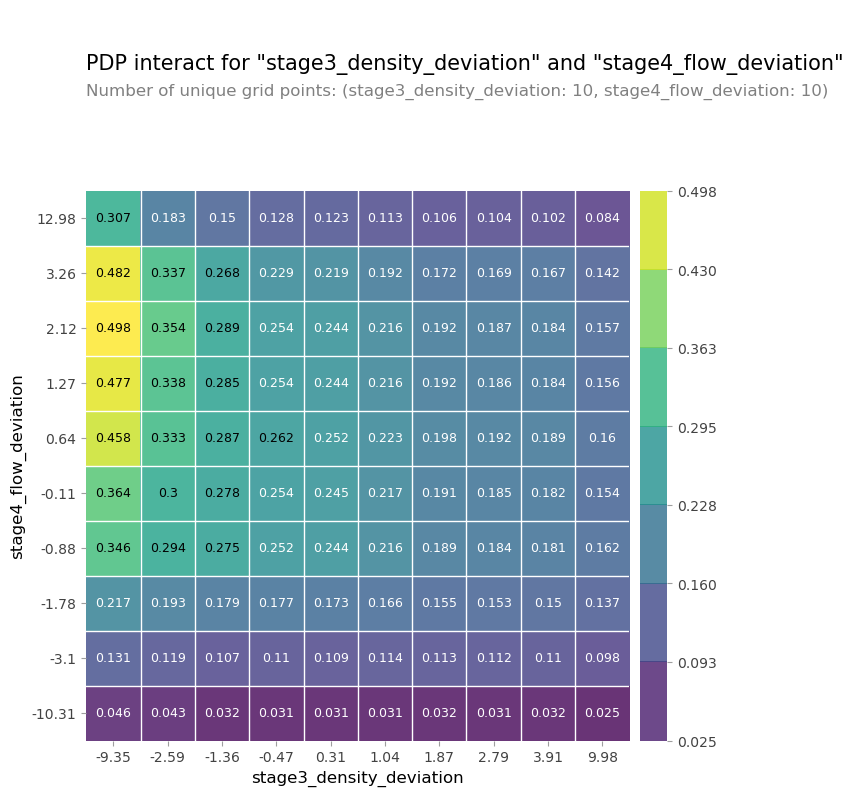

In [69]:
sns.reset_orig()

vars = ['stage3_density_deviation','stage4_flow_deviation']

interaction = pdp_interact(clf.best_estimator_, dataset= x_test, model_features= list(x_test),
                            features=vars,
)
pdp_interact_plot(interaction, plot_type="grid", feature_names=vars)

(<Figure size 750x950 with 3 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fcef3d3d8e0>,
  'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fcef77d2820>})

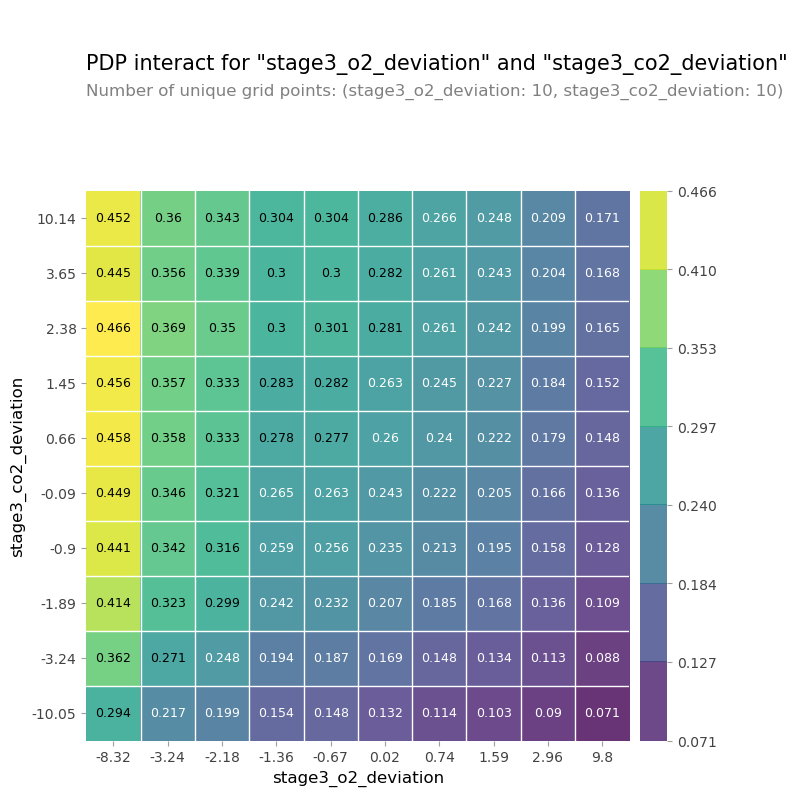

In [70]:
vars = ['stage3_o2_deviation','stage3_co2_deviation']

interaction = pdp_interact(clf.best_estimator_, dataset= x_test, model_features= list(x_test),
                            features=vars,
)
pdp_interact_plot(interaction, plot_type="grid", feature_names=vars)